In [1]:
### New version created to adapt from 230817_CACloudKT_v3.ipynb ###
### two weeks before qualifying exam. Intention: clean up       ###
## data and generally get a simplest, coarsest working model    ###

from multiprocessing import Pool
import os
os.environ['OMP_NUM_THREADS'] = "1"

import numpy as np

import astropy.units as u  
import astropy.constants as c
from astropy.coordinates import SkyCoord

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib 

from astropy.io import fits
from astropy.table import Table, join
from scipy.interpolate import interp1d

from dustmaps.bayestar import BayestarQuery
from dustmaps.vergely2022 import Vergely2022Query
from dustmaps.edenhofer2023 import Edenhofer2023Query

import pickle 
import sys
import os
import tqdm

import emcee
import corner

In [2]:
### Load in CA Cloud Summary Data 
CA_meta = Table(fits.open('../Data/230420_CAResiduals/CA_meta.fits')[1].data)
CAresdir = '/uufs/astro.utah.edu/common/home/u1371365/Data/230420_CAResiduals/'
CAMADGICSresdir = '/uufs/astro.utah.edu/common/home/u1371365/Data/230829_MADGICSResiduals/'
starhorsepath = '/uufs/chpc.utah.edu/common/home/sdss/dr17/env/APOGEE_STARHORSE/APOGEE_DR17_EDR3_STARHORSE_v2.fits'
starhorse = Table.read(starhorsepath, hdu = 1)
starhorse = starhorse['APOGEE_ID', 'dist16', 'dist50', 'dist84', 'AV16', 'AV50', 'AV84']

CA_meta = join(CA_meta, starhorse, keys = 'APOGEE_ID', join_type = 'left')

In [3]:
### Edenhofer Dustmap Coordinates ###
distance = np.linspace(0, 800, 800)


l0, b0 = (163., -8.0)
l_ = np.linspace(l0 - 9., l0 + 9., 800)
b_ = np.linspace(b0 - 9., b0 + 9., 800)
l, b, d = np.meshgrid(l_, b_, distance)
print(l.shape)

coords = SkyCoord(l*u.deg, b*u.deg,
                  distance=distance*u.pc, frame='galactic')
edenhoferquery = Edenhofer2023Query()
# edenhofer = edenhoferquery(coords) * 2.658 # https://zenodo.org/record/7811871




(800, 800, 800)


Optimizing map for querying (this might take a couple of seconds)...


In [4]:
# cen = SkyCoord([])

In [5]:
### Get the edenhofer dustmap from prepped file rather than reading in ###

import h5py
with h5py.File('edenhofer_out.h5', 'r') as f:
    edenhofer = np.array(f['data'])

(array([31., 22., 11.,  9.,  8., 15., 16.,  2., 10.,  8.,  7.,  5., 22.,
         0.,  6.,  3.,  7.,  9.,  3.,  5.]),
 array([  0,   5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,
         65,  70,  75,  80,  85,  90,  95, 100]),
 <BarContainer object of 20 artists>)

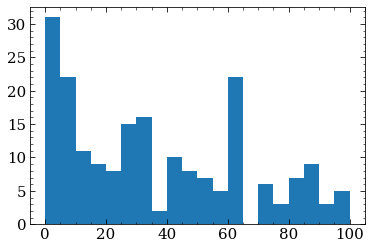

In [6]:
plt.hist(CA_meta['MEDRES_NBIN'], bins = np.arange(0, 105, 5))

In [7]:
np.sum(CA_meta['MEDRES_NBIN'] > 10)

1420

In [8]:
# cloud = 'california'

# l_min, l_max = 154, 172 # longitude bounds, in deg
# b_min, b_max = -17, 1 # latitude bounds, in deg
# d_min, d_max = 70, 1250  #distance bounds, in pc

# delta_l = 0.1 # pixel scale in longitude, in deg
# delta_b = 0.1 # pixel scale in latitude, in deg
# delta_d = 1 # #pixel scale in distance, in pc

# l = np.arange(l_min, l_max, delta_l)
# b = np.arange(b_min, b_max, delta_b)
# d = np.arange(d_min,d_max, delta_d)

# lmesh,bmesh,dmesh = np.meshgrid(l,b,d)

# coords = SkyCoord(l=lmesh*u.deg, b=bmesh*u.deg, distance=dmesh*u.pc,frame='galactic')

# edenhofer = Edenhofer2023Query()
# out=edenhofer(coords)
# out=np.fliplr(out)
# out=np.transpose(out,axes=(2,0,1))

# hdu = fits.PrimaryHDU(out)
# hdu.header['CTYPE1']='GLON'
# hdu.header['CTYPE2']='GLAT'
# hdu.header['CTYPE3']='DISTANCE'
# hdu.header['CRVAl1']=l_max
# hdu.header['CRVAL2']=b_min
# hdu.header['CRVAl3']=d_min
# hdu.header['CRPIX1']=1
# hdu.header['CRPIX2']=1
# hdu.header['CRPIX3']=1
# hdu.header['CDELT1']=delta_l*-1
# hdu.header['CDELT2']=delta_b
# hdu.header['CDELT3']=delta_d

# hdu.writeto('{}_lbd_3D_dust_edenhofer.fits'.format(cloud),overwrite=True)

In [9]:
### Vergely dustmap coordinates (probably not used)
distance_vergely = np.linspace(0, 1000, 200)

l0, b0 = (163., -8.0)
l_vergely_ = np.linspace(l0 - 9., l0 + 9., 200)
b_vergely_ = np.linspace(b0 - 9., b0 + 9., 200)
l_vergely, b_vergely, d_vergely = np.meshgrid(l_vergely_, b_vergely_, distance_vergely)
print(l_vergely.shape)

# coords_vergely = SkyCoord(l_vergely*u.deg, b_vergely*u.deg,
#                   distance=distance_vergely*u.pc, frame='galactic')

# vergelyquery = Vergely2022Query()
# vergely = vergelyquery(coords_vergely)

(200, 200, 200)


In [10]:
lambda0 = 15272.42 
sigma0 = 1.15

def get_wavs(hdulist = None, rv = 0):
    if hdulist is None:
        CRVAL1 = 4.179
        CDELT1 = 6e-06
        LEN = 8575
    else:
        header = hdulist[1].header
        CRVAL1 = header['CRVAL1']
        CDELT1 = header['CDELT1']
        LEN = header['NAXIS1']
        
    wavs = np.power(10, CRVAL1 + CDELT1 * np.arange(LEN))
    wavs = wavs * (1 + rv / 3e5) # allows for shifting to observed frame from rest frame
    return wavs

wavs = get_wavs()
window = (wavs > lambda0 -10) & (wavs < lambda0 + 10)
window_inds = np.where(window)[0]
wavs_window = wavs[window]
window_mask = (wavs_window < lambda0) - 5 | (wavs_window > lambda0 + 5)

def resample_interp(data, rv, resample_wavelengths = wavs, hdu_sel = None):
    wavs_rv = get_wavs(rv = rv, hdulist = hdu_sel)
    interp = interp1d(wavs_rv, data, kind = 'slinear', bounds_error = False)
    
    data_interp = interp(resample_wavelengths)
    
    return data_interp

def dopplershift(v, lambda0 = lambda0):
     return (lambda0 * u.Angstrom * (c.c + v * u.km / u.s) / c.c).to(u.Angstrom).value

In [11]:
def get_ca_res(fname):
    return str(CAresdir + str(fname))

def get_madgics_res(fname):
    return str(CAMADGICSresdir) + str(fname)

def select_stars(tab, l0, b0, radius = 1):
    cond = np.sqrt((tab['GLON'] - l0)**2 + (tab['GLAT'] - b0)**2) < radius
    return np.where(cond)[0]

In [12]:
### Let's make some quality cuts on CA_meta! ADDED 09/28/2023, old selection might be weird ###

lambda0 = 15272.42 
sigma0 = 1.15

from scipy.optimize import curve_fit
def gauss_model(x, mu, sigma, amp):
    return 1 - amp * np.exp(-(x-mu)**2/(2 * sigma0))

def chi2(signal, model):
    return np.nansum((signal - model)**2 / model)

chi2_array = np.zeros(len(CA_meta))
for i in range(len(CA_meta)):
    star = CA_meta[i]
    reshdul = fits.open(get_ca_res(star['FILE']))
    res = reshdul[1].data[window]
    fit, cov = curve_fit(gauss_model, wavs[window], res, p0 = (lambda0, sigma0, 0.03), check_finite = False)
    err = np.sqrt(np.diag(cov))
    chi2_val = chi2(res, gauss_model(wavs[window], *fit))
    chi2_array[i] = chi2_val


CA_meta_full = CA_meta.copy()

with open('goodbad.pickle', mode = 'rb') as f:
    goodbad = pickle.load(f)
## used up until 1003a at least
# CA_meta = CA_meta[goodbad]
# print(len(CA_meta))

# CA_filter = (CA_meta['SNR'] > 70) & (chi2_array < 1/70)
# CA_meta = CA_meta[CA_filter]

### starting 1003b
strict_filter = (CA_meta['SNR'] > 150) & goodbad
CA_meta = CA_meta[strict_filter]
print(len(CA_meta))

/uufs/chpc.utah.edu/sys/installdir/r8/python/3.10.3/lib/python3.10/site-packages/scipy-1.8.0-py3.10-linux-x86_64.egg/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


335


In [13]:
mhdul = fits.open(get_madgics_res(CA_meta['FILE'][0]))
mwavs = get_wavs(hdulist = mhdul) #same from [125:]
mwindow = (mwavs > lambda0 - 9) & (mwavs < lambda0 + 9)
mwavs_window = mwavs[mwindow]

In [14]:
1/np.sqrt(2 * np.pi) / 1.15 * 102e-3

0.03538444573995316

In [15]:
def find_nearest(ll, bb, l_sel = l_, b_sel = b_):

    return np.argmin(np.abs(l_sel - ll)), np.argmin(np.abs(b_sel - bb))

def find_nearest_dist(d):
    return np.argmin(np.abs(distance[:, np.newaxis] - d), axis = 0)

### Added 10.03
def find_radius(ll, bb, count, stars = CA_meta):
    angdist = np.sqrt((ll - CA_meta['GLON'])**2 + (bb - CA_meta['GLAT'])**2)
    angdist_sort = np.sort(angdist)
    return angdist_sort[count]


def dAV_dd(l0, b0, bin_edges):
    l_ind, b_ind = find_nearest(l0, b0)
    sightline = np.copy(edenhofer[b_ind, l_ind, :]) #needs to be b then l then :

    d_min, d_max = bin_edges

    extinction = sightline[(distance > d_min) & (distance < d_max)]
    return np.sum(extinction )

def dAV_dd_star(l0, b0, bin_edges, distances):
    l_ind, b_ind = find_nearest(l0, b0)
    d_min, d_max = bin_edges
    sightline = np.copy(edenhofer[b_ind, l_ind, :])
    sightline[(distance < d_min) | (distance > d_max)] = 0
    sightline_av = (np.cumsum(sightline)) 
    d_ind = find_nearest_dist(distances)

    return np.nanmedian(sightline_av[d_ind])

def Differential_Amplitude(dAv_dd, dd = 1):
    if type(dd) == int:
        return  0.024 * dAv_dd * dd  # 1/(np.sqrt(2 * np.pi) * sigma0) * 102e-3 * dAv_dd * dd
    elif dd.shape == dAv_dd.shape:
        return 0.024 * dAv_dd * dd 
    else:
        return 0.024 * dAv_dd * dd[np.newaxis, :]

        #  return 0.024 * dAv_dd * dd[:, np.newaxis]

def dAV_dd_array(l, b, bins, star_dist, dmap_dist = distance):
    l_ind, b_ind = find_nearest(l, b)
    verg_sightline = np.copy(edenhofer[b_ind, l_ind, :]) 
    dAVdd = np.zeros(len(bins)-1)
    dAVdd_all = np.zeros(len(bins)-1)
    dAVdd_mask = np.zeros(len(bins-1))
    for i in range(len(dAVdd)):
        bin_min, bin_max = bins[i], bins[i+1]
        if bin_min < star_dist:
            dist_max = bin_max
            if bin_max >= star_dist:
                dist_max = star_dist
        else:
            dist_max = -np.inf

            
        dAVdd[i] = np.sum(verg_sightline[(dmap_dist > bin_min) & (dmap_dist <= dist_max)])

        dAVdd_all[i] = np.sum(verg_sightline[(dmap_dist > bin_min) & (dmap_dist <= bin_max)])

    dAVdd_mask = (dAVdd == 0).astype(bool)
    return dAVdd, dAVdd_all, dAVdd_mask

In [16]:
ds = 2.5 # x downsampled
rad = 0.23
sample_dim_l = np.linspace(159, 167, int(8 / (ds * rad)))
sample_dim_b = np.linspace(-12.5 , -4.5, int(8 / (ds * rad)))
sample_grid_l, sample_grid_b = np.meshgrid(sample_dim_l, sample_dim_b)
grid_map_inds = np.array([find_nearest(sample_grid_l.flatten()[i], sample_grid_b.flatten()[i]) for i in range(len(sample_grid_l.flatten()))]).T
grid_map = np.nansum(np.copy(edenhofer[grid_map_inds[1], grid_map_inds[0], :]).reshape(*sample_grid_l.shape, -1), axis = 2)
grid_Nstar = np.array([np.nansum((np.abs((sample_grid_l.flatten()[i] - CA_meta['GLON'])) <= rad) & 
            (np.abs((sample_grid_b.flatten()[i] - CA_meta['GLAT'])) <= rad)) for i in range(len(sample_grid_l.flatten()))]).reshape(*sample_grid_l.shape)

filament_l = (159, 169)
filament_b = (-10, -6)

N_min = 5
radius_min = np.zeros(sample_grid_l.shape)
mgrid = np.mgrid[0:len(sample_dim_l), 0:len(sample_dim_b)]
for i in mgrid[0].flatten():
    for j in mgrid[1].flatten():
        radius_min[i, j] = find_radius(sample_grid_l[i, j], sample_grid_b[i, j], N_min)

radius_max = 0.4
print(np.nansum(radius_min < radius_max))


crit_filament = ((sample_grid_l > filament_l[0]) & (sample_grid_l < filament_l[1]) & 
                 (sample_grid_b > filament_b[0]) & (sample_grid_b < filament_b[1]) &
                 (grid_map > 2.2) & (radius_min < 0.5)) #(grid_Nstar > 5) & (grid_Nstar <= 10))

crit_background =  (((sample_grid_l <= filament_l[0]) | (sample_grid_l >= filament_l[1]) |
                 (sample_grid_b <= filament_b[0]) | (sample_grid_b >= filament_b[1])) &
                 (grid_map <= 1.5) & (radius_min < radius_max)) #(grid_Nstar > 5) & (grid_Nstar <= 10))

# crit_coverage = (np.sum() => 1 & )

N_filament = np.sum(crit_filament)
N_background = np.sum(crit_background)
print(np.sum(crit_filament))
print(np.sum(crit_background))

17
15
3


(array([ 0.,  0.,  0.,  0.,  1.,  4.,  5.,  7., 18., 15., 15.,  8.,  7.,
        10.,  6.,  1.,  4.,  6.,  3.,  7.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 20 artists>)

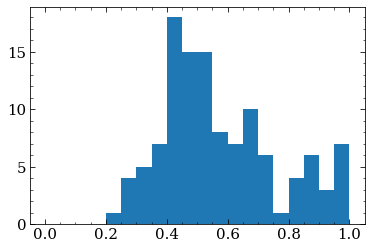

In [17]:
plt.hist(radius_min.flatten(), bins = 20, range = (0, 1))


In [18]:
np.mgrid[:5, :6][0].flatten()

array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3,
       3, 3, 4, 4, 4, 4, 4, 4])

In [19]:
10 % 5

0

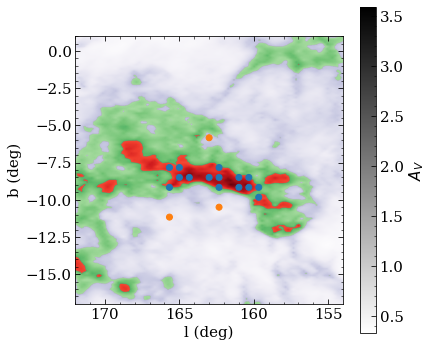

In [20]:
if True: 
    fig, ax = plt.subplots(figsize = (6,6))

    im = ax.imshow(np.nansum(edenhofer, axis = 2), origin = 'lower', cmap = 'binary', extent = (l0-9, l0+9, b0-9, b0+9))
    ax.set_xlabel('l (deg)')
    ax.set_ylabel('b (deg)')
    # ax.scatter(CA_meta['GLON'], CA_meta['GLAT'], marker = '.')

    masks = (np.nansum(edenhofer, axis = 2) >= 2.2).astype(float)
    masks_2 = ((np.nansum(edenhofer, axis = 2) >= 1.5) & (np.nansum(edenhofer, axis = 2) < 2.2)).astype(float)
    masks_3 = (np.nansum(edenhofer, axis = 2) < 1.5).astype(float)
    im_mask = ax.imshow(np.nansum(edenhofer, axis = 2), origin = 'lower', cmap = 'Reds', alpha = masks, extent = (l0-9, l0+9, b0-9, b0+9))
    im_mask_2 = ax.imshow(np.nansum(edenhofer, axis = 2), origin = 'lower', cmap = 'Greens', alpha = masks_2, extent = (l0-9, l0+9, b0-9, b0+9))
    im_mask_3 = ax.imshow(np.nansum(edenhofer, axis = 2), origin = 'lower', cmap = 'Purples', alpha = masks_3, extent = (l0-9, l0+9, b0-9, b0+9))


    ax.scatter(sample_grid_l, sample_grid_b, alpha = (crit_filament).astype(float), vmin = 0, vmax = 8)
    ax.scatter(sample_grid_l, sample_grid_b, alpha = (crit_background).astype(float), vmin = 0, vmax = 8)

    fig.colorbar(im, label = '$A_V$')
    xmin, xmax = ax.get_xlim()
    ax.set_xlim(xmax, xmin)

    plt.show()

In [21]:
l_fil, b_fil, AV_fil = (sample_grid_l[crit_filament].flatten(), sample_grid_b[crit_filament].flatten(),
                        grid_map[crit_filament].flatten())
l_off, b_off, AV_off = (sample_grid_l[crit_background].flatten(), sample_grid_b[crit_background].flatten(),
                        grid_map[crit_background].flatten())

l_sample, b_sample, AV_sample = (np.concatenate([l_fil, l_off]), np.concatenate([b_fil, b_off]),
                                  np.concatenate([AV_fil, AV_off]))

# selected_inds = []
# for i in range(len(l_sample)):
#     l_center, b_center = l_sample[i], b_sample[i]
#     selection = select_stars(CA_meta, l_center, b_center, radius = rad)
#     print(len(selection))
#     selected_inds.append(selection)

radius_min_fil = radius_min[crit_filament].flatten()
radius_min_off = radius_min[crit_background].flatten()
radius_sample = np.concatenate([radius_min_fil, radius_min_off])

selected_inds = []
for i in range(len(l_sample)):
    l_center, b_center = l_sample[i], b_sample[i]
    rad_i = radius_sample[i]
    selection = select_stars(CA_meta, l_center, b_center, radius = rad_i)
    print(len(selection))
    selected_inds.append(selection)

5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5


In [22]:
# def find_nearest_v (ll, bb, l_sel = l_vergely_, b_sel = b_vergely_):

#     return np.argmin(np.abs(l_sel - ll)), np.argmin(np.abs(b_sel - bb))

# def find_nearest_dist_v (d):
#     return np.argmin(np.abs(distance_vergely[:, np.newaxis] - d), axis = 0)

# def dAV_dd_array_v(l, b, bins, star_dist, dmap_dist = distance_vergely):
#     l_ind, b_ind = find_nearest_v(l, b)
#     verg_sightline = np.copy(vergely[b_ind, l_ind, :]) 
#     dAVdd = np.zeros(len(bins)-1)
#     dAVdd_all = np.zeros(len(bins)-1)
#     dAVdd_mask = np.zeros(len(bins-1))
#     for i in range(len(dAVdd)):
#         bin_min, bin_max = bins[i], bins[i+1]
#         if bin_min < star_dist:
#             dist_max = bin_max
#             if bin_max >= star_dist:
#                 dist_max = star_dist
#         else:
#             dist_max = -np.inf

            
#         dAVdd[i] = np.sum(verg_sightline[(dmap_dist > bin_min) & (dmap_dist <= dist_max)])

#         dAVdd_all[i] = np.sum(verg_sightline[(dmap_dist > bin_min) & (dmap_dist <= bin_max)])

#     dAVdd_mask = (dAVdd == 0).astype(bool)
#     return dAVdd, dAVdd_all, dAVdd_mask

In [23]:
class sightline:
    ### Container object for stars, sightline dAV_dd, velocity, and spaxel assignment.
    def __init__(self, stars, bins = None, **kwargs):
        self.stars = stars
        dist = self.stars['DIST']

        if bins is not None:
            h = np.histogram(dist, bins)[0]
            self.bins = np.insert(bins[1:][h != 0], 0, bins[0])
            self.bin_inds = np.digitize(dist, bins)
        else:
            self.make_bins()
            self.bin_inds = np.digitize(dist, self.bins)  
        self.rvelo = np.zeros(len(self.bins) - 1)
        self.get_DIBs(**kwargs)
        self.init_signals = self.model_signals(self.rvelo, self.dAVdd)
        self.ndim = len(self.voxel_dAVdd)
        self.nsig = len(self.stars)
        
    def make_bins(self, binsep = 10, dmin = 0):
        ### Assigns stars to distance bins if bins are not already supplied.
        dist = self.stars['DIST']
        bins = np.sort(np.insert(np.delete(dist, np.where(dist <= dmin)[0]), 0, dmin))

        i = 0
        while i >= 0:
            try:
                next_bin = np.min(bins[bins > bins[i]])
            except:
                print('broke:')
                print(bins[bins > bins[i]])
                print(len(self.stars))

            bins[i+1] = np.max([next_bin, bins[i] + binsep]) + 0.01
            if bins[i+1] >= np.max(dist):
                bins = bins[:i+2]
                i = -np.inf
            i = i+1
        
        self.bins = bins
            
    def get_DIBs(self, MADGICS = False):
        signals = np.zeros((len(self.stars), len(wavs_window)))
        signal_errs = np.zeros((len(self.stars), len(wavs_window)))
        dAVdd = np.zeros((len(self.stars), len(self.bins)-1))
        dAVdd_all = np.zeros((len(self.stars), len(self.bins)-1))
        dAVdd_mask =np.zeros((len(self.stars), len(self.bins)-1)).astype(bool)
        # dAVdd_v = np.zeros((len(self.stars), len(self.bins)-1))
        # print(len(dAVdd_all))
        if MADGICS:
            signals_aspcap = np.zeros((len(self.stars), len(wavs_window)))
            signal_errs_aspcap = np.zeros((len(self.stars), len(wavs_window)))


        # dAVdd = np.zeros(len(self.bins))

        for i in range(len(self.stars)):
            star = self.stars[i]
            res_hdul = fits.open(get_ca_res(star['FILE']))
            signals[i, :] = res_hdul[1].data[window]
            signal_errs[i, :] = res_hdul[2].data[window]
            l, b = star['GLON'], star['GLAT']
            dAVdd[i], dAVdd_all[i], dAVdd_mask[i] = dAV_dd_array(l, b, self.bins, star['DIST'])
            # dAVdd_v[i], _, __ = dAV_dd_array_v(l, b, self.bins, star['DIST'])


            if MADGICS:
                signals_aspcap[i, :] = np.copy(signals[i, :])
                signal_errs_aspcap[i, :] = np.copy(signal_errs[i, :])
                res_hdul_m = fits.open(get_madgics_res(star['FILE']))
                signals[i, :] = res_hdul_m[1].data[0, 125:][window]
                # signal_errs[i, :] = res_hdul_m[5].data[0, 125:][window]
                # print(res_hdul[2].data.shape)
                # errs = resample_interp(res_hdul[2].data, rv = - star['VHELIO_AVG'])
                # # if 
                # errs = resample_interp(errs, rv = np.median(res_hdul_m[3].data['MADGICS_VBARY']))
                # signal_errs[i, :] = errs[window]



        self.signals = signals
        self.signal_errs = signal_errs
        self.dAVdd = dAVdd
        self.voxel_dAVdd = np.nanmedian(dAVdd_all, axis = 0)
        self.voxel_dAVdd_std = np.nanstd(dAVdd_all, axis = 0, ddof = 1)
        self.dAVdd_mask = dAVdd_mask.astype(bool)
        # self.dAVdd_v = dAVdd_v
        if MADGICS:
            self.signals_aspcap = signals_aspcap
            self.signal_errs_aspcap = signal_errs_aspcap
        # print(self.voxel_dAVdd.shape)
        # self.dAVdd = dAV_dd_array(np.median(self.stars['GLON']), np.median(self.stars['GLAT']), 
        #                           self.bins, np.max(self.bins))

    def model_signals(self, rvelo, dAVdd = None):
        if dAVdd is None:
            dAVdd = self.dAVdd
        # print('dAVdd shape: ', dAVdd.shape)
        # dAVdd[self.dAVdd_mask] = 0
        signals = np.zeros((len(self.stars), len(wavs_window)))
        peak_wavelength = dopplershift(rvelo)
        wavs_grid = np.tile(wavs_window, (len(self.bins) - 1, 1))
        voxel_DIB_unscaled = np.exp(-(wavs_grid - peak_wavelength[:, np.newaxis])**2 / (2 * sigma0**2))
        amp = Differential_Amplitude(dAVdd, self.bins[1:]-self.bins[:-1])

        def single_signal(amp, bindex):
            amp[bindex :] = 0 # THIS MIGHT NEED TO BE -1

            voxel_DIB_scaled = -voxel_DIB_unscaled *  amp[:, np.newaxis] 
            summed_DIB = np.sum(voxel_DIB_scaled, axis = 0)
            # continuum = lambda x, m, b : m * (x - lambda0) + b
            # cont = continuum(wavs_window, 0, b)
            return summed_DIB  + 1


        for i in range(len(self.stars)):
            star = self.stars[i]
            dAVdd_star = dAVdd[i, :]
            # amp = Differential_Amplitude(dAVdd_star, self.bins[1:]-self.bins[:-1])
            amp = Differential_Amplitude(dAVdd_star, 1)

            bin_index = self.bin_inds[i]
            # signals[i, :] = single_signal(bin_index)
            signals[i, :] = single_signal(amp, bin_index)
        return signals
    
    # def intake_full(self, sampler_full):
    #     self.sampler_full = sampler_full
  
    def intake(self, sampler):
        self.sampler = sampler

        samples = sampler.chain[:, int(sampler.chain.shape[1]/2):, :].reshape((-1, sampler.chain.shape[-1]))

        medians = np.nanmedian(samples[:, :], axis = 0)
        stdevs = np.nanstd(samples, axis = 0, ddof = 1)


        med_dAV_dd = medians[self.ndim:].reshape(-1, self.ndim)
        std_dAV_dd = stdevs[self.ndim:].reshape(-1, self.ndim)
        self.dAVddd_derived = med_dAV_dd
        self.dAVdd_derived_err = std_dAV_dd

    def intake_coords(self, l, b, AV = None):
        self.l = l
        self.b = b
        self.AV = AV


In [24]:
sightlines = []
for i in range(len(selected_inds)):
    indx = selected_inds[i]
    sightlines.append(sightline(CA_meta[indx], MADGICS = False))
    sightlines[i].intake_coords(l_sample, b_sample, AV = AV_sample)

In [25]:
len(sightlines)

18

In [26]:
# fig, ax = plt.subplots()
# for i in range(len(sightlines[1].dAVdd)):
#     ax.plot(sightlines[1].dAVdd[i, :], color = 'C'+str(i))
#     # ax.plot(sightlines[1].dAVdd_v[i, :]* 5, color = 'C'+str(i), linestyle = 'dashed')

In [27]:
from matplotlib.backends.backend_pdf import PdfPages
if False:
    # with PdfPages('Temp/Sightlines_plots_a.pdf') as pdf:
    for sl in sightlines:
        fig, ax = plt.subplots(figsize = (8, 16))
        d_order = np.argsort(sl.stars['DIST'])
        for j in range(len(d_order)):
            ii = d_order[j]
            ax.plot(wavs_window, sl.signals[ii, :] + 0.05 * j, color = 'C{}'.format(j))

        plt.show()

if False:
    # with PdfPages('Temp/Sightlines_plots_a.pdf') as pdf:
    for i in range(len(sightlines)):
        sl_i = sightlines[i]
        nvel = len(sl_i.bins)-1
        fig, ax = plt.subplots(figsize = (16, 6))
        for j in range(nvel):
            chain_j = sl_i.sampler.chain[:, :, j].T
            ax.plot(chain_j+ j * 50)
        plt.show()

In [28]:
# chain = sl_i.sampler.chain[:, :, 3].T
# plt.plot(chain)

In [29]:
# model_signals(self, rvelo, dAVdd = None):
sl = sightlines[0]
signals = np.zeros(sl.signals.shape)
signal_errs = np.zeros(sl.signals.shape)
def loglikely_2(v, av, sl = sl, **kwargs):

    # v = p[:int(len(p)/2)]
    # av = p[int(len(p)/2):]
    # av = np.tile(av, len(sl.stars)).reshape(len(sl.stars), -1)

    signal = sl.signals
    sigma = sl.signal_errs

    # print('loglikely av shape' ,av.shape)
    val = - 0.5 * np.nansum((signal - sl.model_signals(v, dAVdd = av))**2 / (sigma**2)) # IS THIS WRONG
    if np.isnan(val):
        # print('fail loglikely')
        return -np.inf
    else:
        return val
    # return - 0.5 * np.sum((signal - sl.model_signals(v, dAVdd = av))**2 / (sigma**2)) 

# def logprior_v(v, v_max = 5, prior_mult = 1, **kwargs):
#     if (np.any(np.abs(v) > prior_mult * v_max)):
#         # print('logprior v -inf')
#         return -np.inf
#     return 0.0


def logprior_v(v, v_max = 5, prior_mult = 1, **kwargs):
    if (np.any(v < -8)) or (np.any(v > 18)):
        # print('logprior v -inf')
        return -np.inf
    return 0.0

def logprior_davdd(av, AV_base = 5, AV_max = 10):   
    # if (np.any(np.abs(av - AV_base) > AV_max)):
    #     # print('av -inf')
    #     return -np.inf
    if ((np.any(av < 0))):
        # print('logprior av -inf')
        return -np.inf
    return 0.0

def logprior_davdd_reg(av,sl, mask = None, **kwargs):
    # print(av.shape)
    # av = np.tile(av, len(sl.stars)).reshape(len(sl.stars), -1) # FOR NOW 
    av = np.copy(av)
    mask = sl.dAVdd_mask
    # mask = av == 0
    av[mask] = np.nan

    # avmed = np.nanmedian(av, axis = 0)
    # avstd = np.nanstd(av, ddof = 1,  axis = 0)
    # avstd[np.isnan(avstd)] = 0.2

    avmed = sl.voxel_dAVdd
    # print(avmed.shape)
    avstd = sl.voxel_dAVdd_std * 12 # should be 10
    # print(avstd.shape)

    # print(av.shape)
    # return 0.0
    # lp_val = np.nansum(np.log(1/(np.sqrt(2 * np.pi) * avstd))) - 0.5 * np.nansum((av - avmed[:, np.newaxis])**2 / (2 * avstd[:, np.newaxis]**2))# first part might not be needed
    # lp_val = np.nansum(- 0.5 * np.nansum((av - avmed[np.newaxis, :])**2 / (2 * avstd[np.newaxis, :]**2)))# first part might not be needed
    lp_val = -np.nansum(np.log(np.sqrt(2 * np.pi))) + np.nansum(- 0.5 * np.nansum((av - avmed)**2 / (2 * avstd**2)))# first part might not be needed

    
    return lp_val
    # return np.sum(np.log(1/(avstd[:, np.newaxis] * np.sqrt(2 * np.pi ))) - 0.5 * (av - avmed[:, np.newaxis])**2 / (2 * avstd[:, np.newaxis]**2)) # first part might not be needed

def logprob_2(p, sl = sl, logprior = logprior_v, loglikely = loglikely_2, **kwargs):
    ndim = len(sl.voxel_dAVdd)
    v = p[ :ndim]
    av = p[ndim:].reshape(-1, ndim)

    # print(av.shape)

    lp = logprior(v, **kwargs)
    lp_davdd = logprior_davdd(av, AV_base = sl.dAVdd)
    lp_davdd_reg = logprior_davdd_reg(av, sl, **kwargs)

    if (not np.isfinite(lp)) | (not np.isfinite(lp_davdd)) | (not np.isfinite(lp_davdd_reg)):
        # print('fail logprob')
        return -np.inf
    return lp + lp_davdd + lp_davdd_reg + loglikely_2(v, av, sl = sl, **kwargs)

def logprob_avfix(p, av = None, sl = sl, logprior = logprior_v, loglikely = loglikely_2, **kwargs):
    ndim = len(sl.voxel_dAVdd)
    v = p[:ndim]

    # av = av.reshape(-1, ndim)

    lp = logprior(v, **kwargs)
    if (not np.isfinite(lp)):
        return -np.inf
    return lp + loglikely_2(v, av, sl = sl, **kwargs)



In [30]:
import time

In [31]:
def MCMC_scary(sl, steps = 1000, nwalkers = 100, pool = None):
    ndim = len(sl.voxel_dAVdd) 
    nstar = len(sl.stars)
    ndim_amp = int(ndim + ndim * nstar)
    

    # dAVdd_prior = sl.dAVdd[:]
    # dAVdd_prior[dAVdd_prior == 0] = np.nan 
    # dAVdd_prior_med = np.nanmedian(dAVdd_prior, axis = 1)
    # dAVdd_prior_std = np.nanstd(dAVdd_prior, axis = 1, ddof = 1)
    # gaussparams = (dAVdd_prior_med, dAVdd_prior_std)
    # print(gaussparams)

    # with Pool(15) as pool:

    sampler = emcee.EnsembleSampler(nwalkers, ndim_amp , logprob_2, 
                                    kwargs={'sl': sl,  'prior_mult':  1, 'v_max': 20, 'sigma': signal_errs}, pool = pool)
    # init = 12.5 *(np.random.random((nwalkers, ndim_amp)) - 0.5)
    init = 10 *  (np.random.random((nwalkers, ndim_amp)) - 0.5)

    init[:, ndim:] = np.abs(sl.dAVdd.ravel()[np.newaxis, :] + 0.1*(np.random.random(init[:, ndim:].shape)-0.5))
    print('NDIM:', ndim, 'NSTAR:', nstar, 'INITSHAPE:', init.shape)
    
    sampler.run_mcmc(init,  steps, progress = True);
    
    return sampler, ndim, ndim_amp

# def MCMC_vonly(sl, sampler_previous, steps = 1000, nwalkers = 100, pool = None):
#     ndim = len(sl.voxel_dAVdd) 
#     nstar = len(sl.stars)

#     samples = sampler_previous.chain[:, 200:, :].reshape((-1, sampler_previous.chain.shape[-1]))
#     medians = np.nanmedian(samples[50:, :], axis = 0)
#     av = medians[ndim:].reshape(-1, ndim)
    

#     sampler = emcee.EnsembleSampler(nwalkers , ndim, logprob_avfix, 
#                                     kwargs={'sl': sl,  'prior_mult':  4, 'v_max': 5, 'sigma': signal_errs}, pool = pool) 
#     init = 12.5 *(np.random.random((nwalkers, ndim)) - 0.5)

#     # init[:, ndim:] = np.abs(sl.dAVdd.ravel()[np.newaxis, :] + 0.1*(np.random.random(init[:, ndim:].shape)-0.5))
#     print('NDIM:', ndim, 'NSTAR:', nstar, 'AVFIXED')
    
#     sampler.run_mcmc(init,  steps, progress = True );
    
#     return sampler, ndim


In [32]:
stp = 5000
# sampler, ndim, ndim_amp = MCMC_scary(a, steps = stp, nwalkers = 500)
# sampler1, ndim1, ndim_amp1 = MCMC(a1, steps = stp)
# sampler2, ndim2, ndim_amp2 = MCMC(a2, steps = stp)
# sampler3, ndim3, ndim_amp3 = MCMC(a3, steps = stp)

run_label = '1012b'
save_individual = False

first_run = True

if first_run:
    if not os.path.exists(os.getcwd() + '/RUNS/' + run_label):
        os.makedirs(os.getcwd() +'/RUNS/' + run_label)
    with Pool(20) as pool:
        for i in range(len(sightlines)):
            try:
                sl_i = sightlines[i]
                smplr, ndm, ndm_amp = MCMC_scary(sl_i, steps = stp, nwalkers = 500, pool = pool)
                # smplr_array.append(smplr)
                # mid = time.time()
                # print('Time mid - start', mid - start) # beat 7:22
                # smplr_, ndim_ = MCMC_vonly(sl_i, smplr, steps = 1200, nwalkers = 100, pool = None)
                # end = time.time()
                # print('Time end - start:',(end - start)/60)
                sl_i.intake(smplr)
                state = 'success'
            except Exception as e:
                print('Something went wrong')
                sl_i = None 
                state = 'fail'
                with open('RUNS/' + run_label + '/FAILS.txt', mode = 'a') as fails:
                    fails.write(str(e))
                
            with open('RUNS/' + run_label + '/LOG.txt', mode = 'a') as log:
                logstring = time.asctime() + ' | ' + str(i) + ' | ' + state + '\n'
                log.write(logstring)
            
            if save_individual == True:
                with open('RUNS/' + run_label + '/sl_{}.pickle'.format(i), mode = 'wb') as f:
                    pickle.dump(sl_i, f)

# sampler, ndim, ndim_amp = smplr, ndm, ndm_amp

NDIM: 5 NSTAR: 5 INITSHAPE: (500, 30)


100%|██████████| 5000/5000 [08:48<00:00,  9.46it/s]


NDIM: 5 NSTAR: 5 INITSHAPE: (500, 30)


100%|██████████| 5000/5000 [08:56<00:00,  9.32it/s]


NDIM: 5 NSTAR: 5 INITSHAPE: (500, 30)


100%|██████████| 5000/5000 [08:51<00:00,  9.40it/s]


NDIM: 5 NSTAR: 5 INITSHAPE: (500, 30)


100%|██████████| 5000/5000 [08:53<00:00,  9.37it/s]


NDIM: 5 NSTAR: 5 INITSHAPE: (500, 30)


100%|██████████| 5000/5000 [08:48<00:00,  9.46it/s]


NDIM: 5 NSTAR: 5 INITSHAPE: (500, 30)


100%|██████████| 5000/5000 [08:58<00:00,  9.28it/s]


NDIM: 5 NSTAR: 5 INITSHAPE: (500, 30)


100%|██████████| 5000/5000 [08:55<00:00,  9.33it/s]


NDIM: 4 NSTAR: 5 INITSHAPE: (500, 24)


100%|██████████| 5000/5000 [08:57<00:00,  9.31it/s]


NDIM: 4 NSTAR: 5 INITSHAPE: (500, 24)


100%|██████████| 5000/5000 [08:54<00:00,  9.36it/s]


NDIM: 5 NSTAR: 5 INITSHAPE: (500, 30)


100%|██████████| 5000/5000 [08:54<00:00,  9.35it/s]


NDIM: 5 NSTAR: 5 INITSHAPE: (500, 30)


100%|██████████| 5000/5000 [08:50<00:00,  9.42it/s]


NDIM: 5 NSTAR: 5 INITSHAPE: (500, 30)


100%|██████████| 5000/5000 [08:54<00:00,  9.35it/s]


NDIM: 5 NSTAR: 5 INITSHAPE: (500, 30)


100%|██████████| 5000/5000 [08:57<00:00,  9.30it/s]


NDIM: 5 NSTAR: 5 INITSHAPE: (500, 30)


100%|██████████| 5000/5000 [08:50<00:00,  9.42it/s]


NDIM: 5 NSTAR: 5 INITSHAPE: (500, 30)


100%|██████████| 5000/5000 [08:58<00:00,  9.29it/s]


NDIM: 5 NSTAR: 5 INITSHAPE: (500, 30)


100%|██████████| 5000/5000 [08:56<00:00,  9.32it/s]


NDIM: 5 NSTAR: 5 INITSHAPE: (500, 30)


100%|██████████| 5000/5000 [08:56<00:00,  9.33it/s]


NDIM: 5 NSTAR: 5 INITSHAPE: (500, 30)


100%|██████████| 5000/5000 [08:51<00:00,  9.41it/s]


In [33]:
name = run_label

# first_run = True

if first_run:
    f = open('RUNS/' + run_label + '/sightlines_{}.pickle'.format(name),'wb')
    pickle.dump(sightlines, f )
    f.close()

if not first_run:
    # f = open('sightlines_{}.pickle'.format(name), 'rb')
    f = open('RUNS/' + run_label + '/sightlines_{}.pickle'.format(name), 'rb')

    sightlines = pickle.load(f)
    f.close()

### RUNS/0918a/sightlines_0919a: first time running with selection by filament/not. MADGICS residuals (thought it was ASPCAP). Edenhofer map.
### RUNS/0920a/sightlines_0920a: first time running with selection by filament/not. Edenhofer map. Uses Nstar > 2
### RUNS/0926a/sightlines_0926a: selection updated using Nstar > 6 per sightline
### RUNS/0927a/sightlines_0927a: removed the max on the uninformative prior on A(V) (just to see)
### RUNS/0928a/sightlines_0928a: kept changes from previous. Remove SNR < 70 & 1/Gaussian chi2 < 1/something
### RUNS/0929a/sightlines_0929a: nixed filtering from previous, instead manual by-eye from 230921_qualfigs.ipynb
### RUNS/1002a/sightlines_1002a: switched to v4 notebook.
### RUNS/1002b/sightlines_1002b: switched to v4 notebook. Expanded prior on AV from +- 15 to +- 20
### RUNS/1002c/sightlines_1002c: switched to v4 notebook. Expanded prior on AV from +- 15 to +- 20. 2000 runs
### RUNS/1003a/sightlines_1003a: switched to v4 notebook. Expanded prior on AV from +- 15 to +- 20. 2000 runs. MADGICS
### RUNS/1003b/sightlines_1003b: cut to remove SNR < 150, plus manual filtering. Uses flexible aperture radius to max angsep 0.5 deg w/ 8 stars in sl
### RUNS/1003c/sightlines_1003c: cut to remove SNR < 150, plus manual filtering. Uses flexible aperture radius to max angsep 0.5 deg w/ 5 stars in sl
### RUNS/1009b/sightlines_1009b: terrible idea: using a prior based on CO. failed. forgot that CO is in LSR and that's way off...
### RUNS/1010a/sightlines_1010a: adjusted LSR to galactic (hopefully); vel prior -8 to +18
### RUNS/1011a/sightlines_1011a: adjusted LSR to galactic (hopefully); vel prior -8 to +18, 2200 steps
### RUNS/1012a/sightlines_1012a: adjusted LSR to galactic (hopefully); vel prior -8 to +18, 5000 steps

In [34]:
# sl_i.sampler.lnprobability.shape

In [35]:
# sl_i.sampler.chain.shape

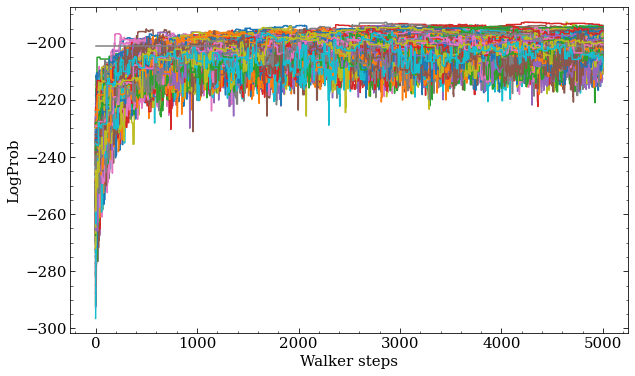

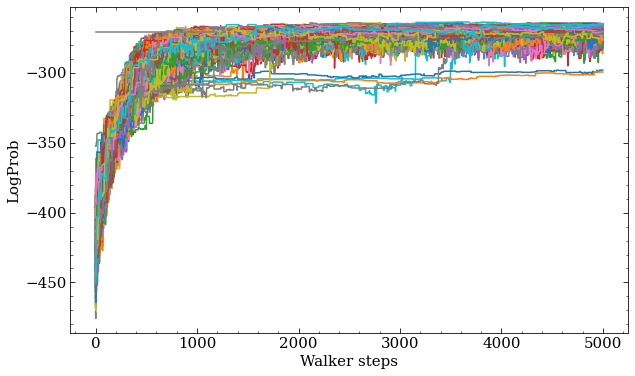

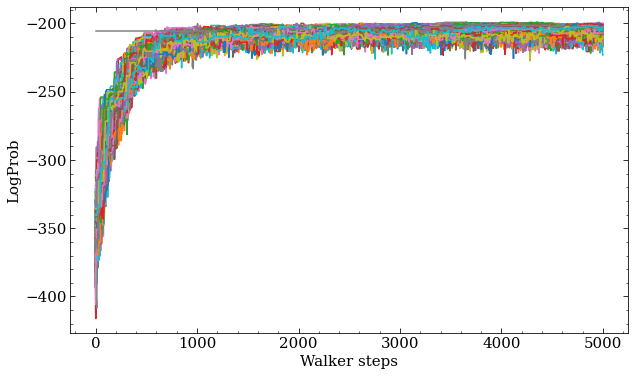

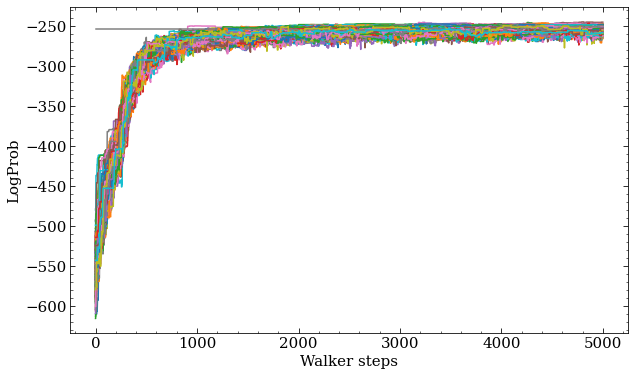

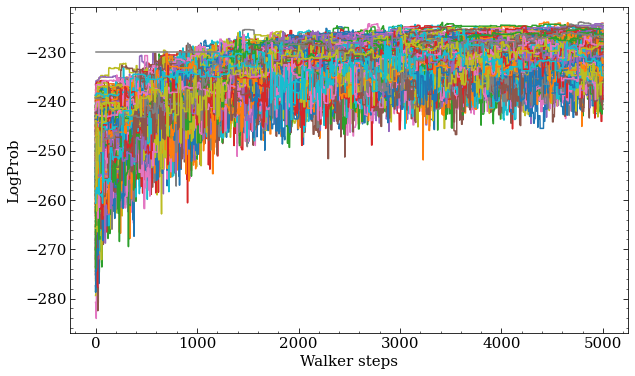

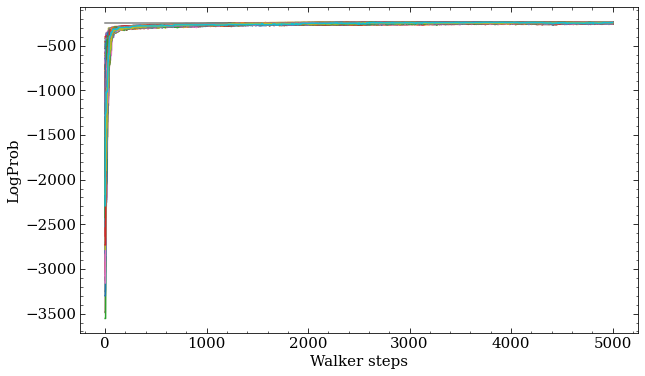

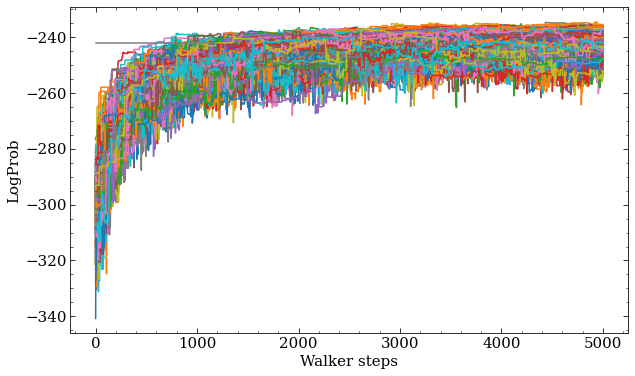

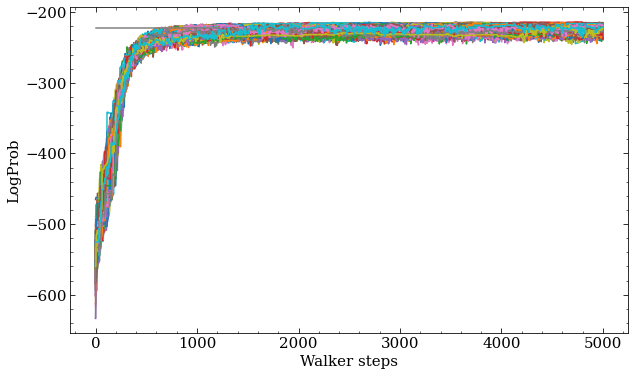

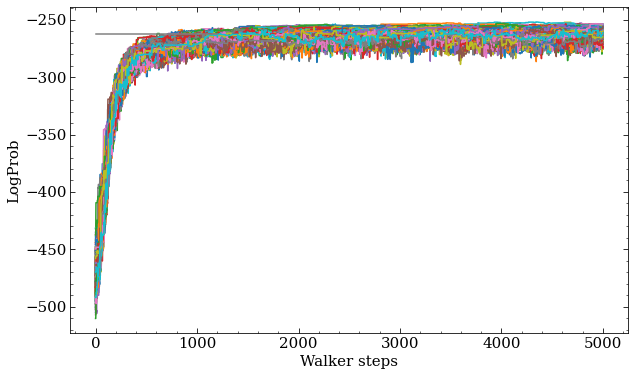

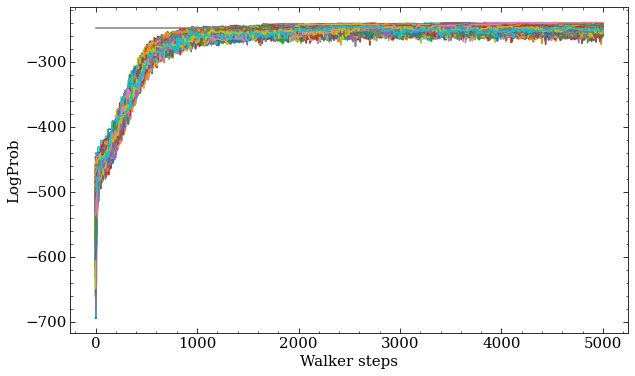

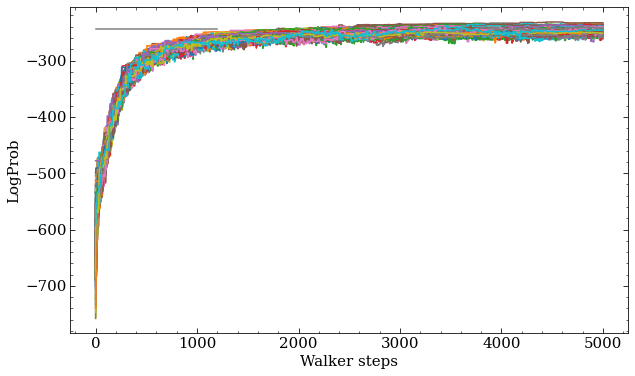

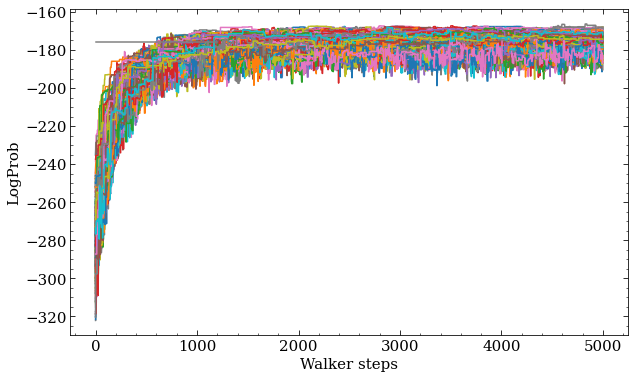

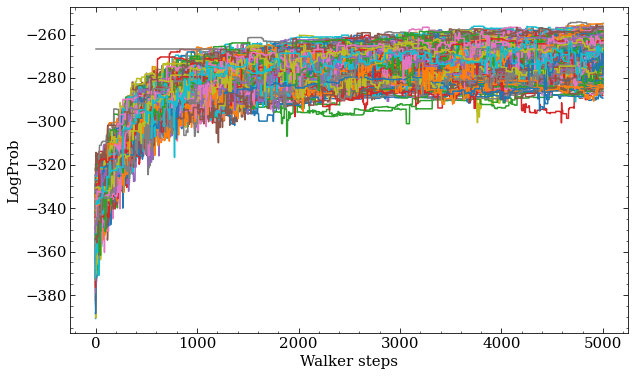

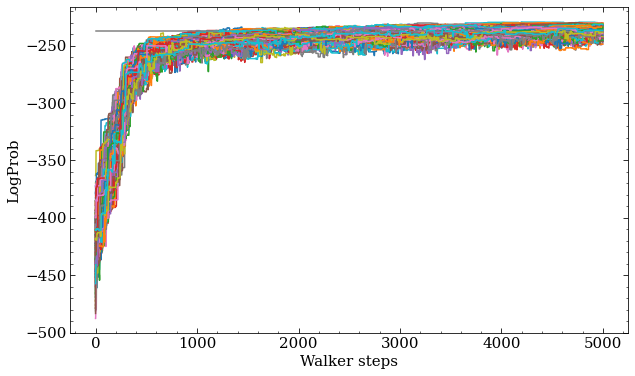

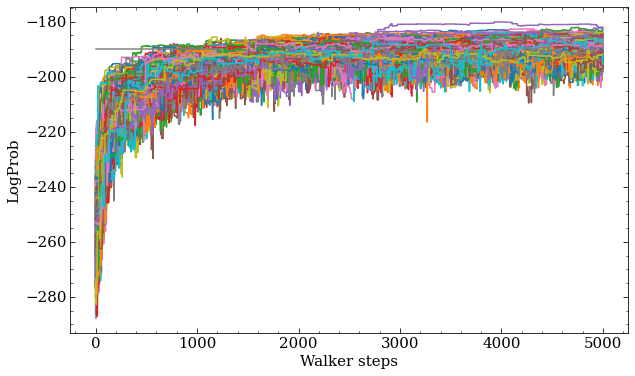

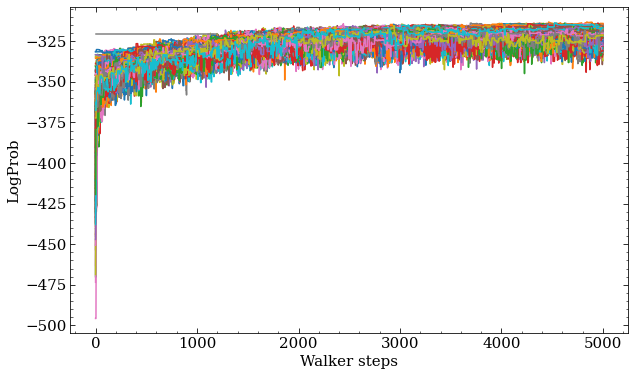

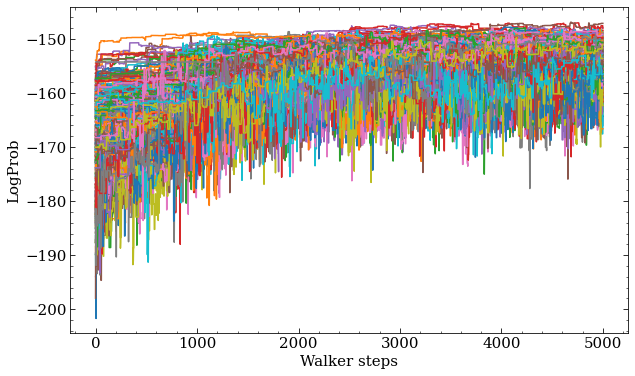

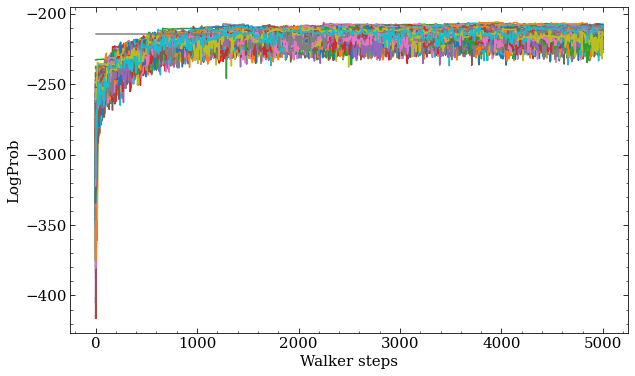

In [36]:
lp_all = np.zeros(len(sightlines))
for i in range(len(sightlines)):
    sl_i = sightlines[i]

    lp = sl_i.sampler.lnprobability
    lp_end_med = np.nanmedian(lp[:, -100:])
    fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (10, 6))
    ax.plot(lp.T)
    ax.plot([0, 1200], [lp_end_med, lp_end_med], color = 'grey')
    ax.set_xlabel("Walker steps")
    ax.set_ylabel('LogProb')
    lp_all[i] = lp_end_med
    

Text(0, 0.5, '$\\ln p$')

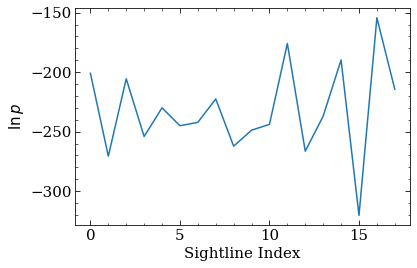

In [37]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(sightlines)), lp_all)
ax.set_xlabel('Sightline Index')
ax.set_ylabel('$\ln p$')

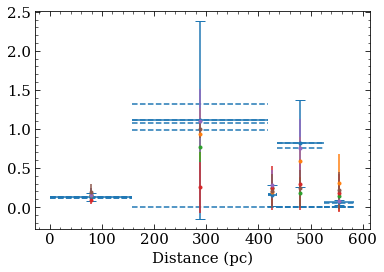

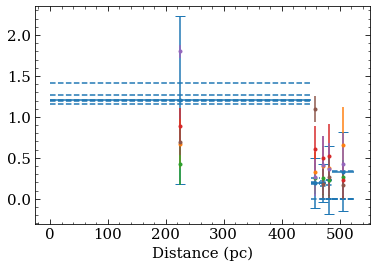

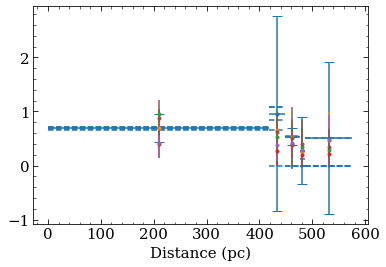

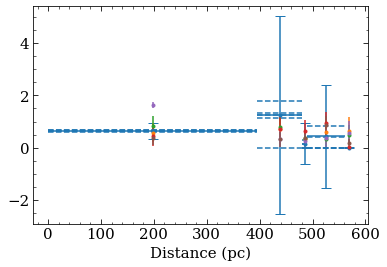

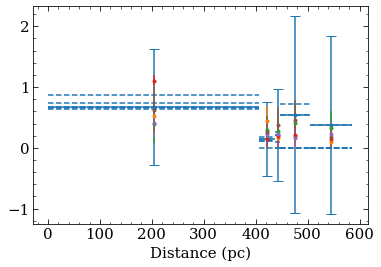

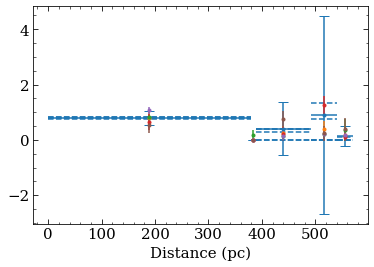

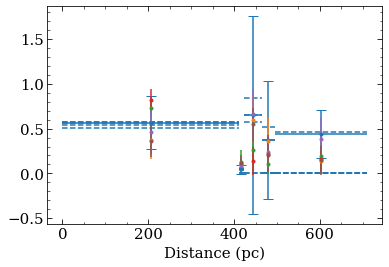

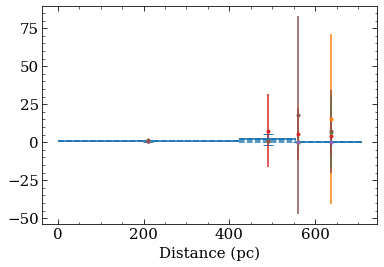

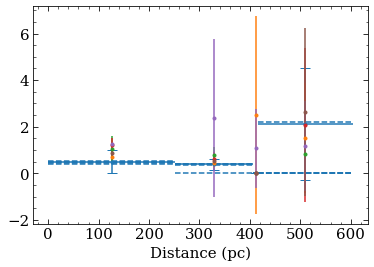

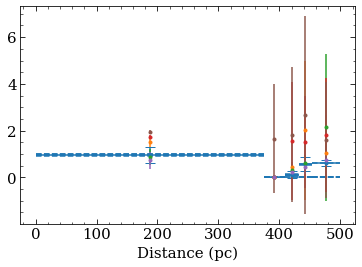

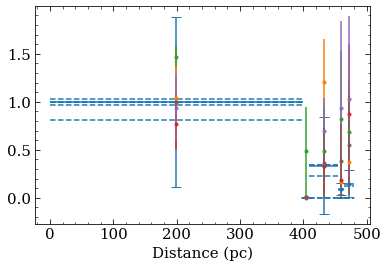

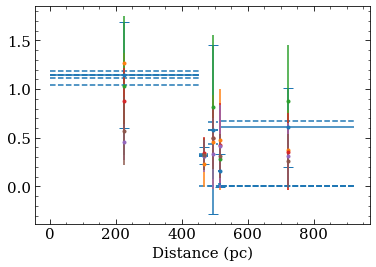

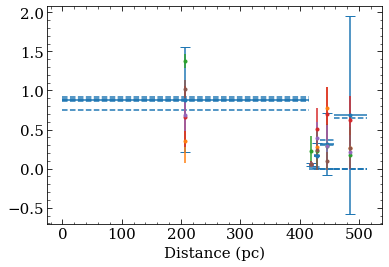

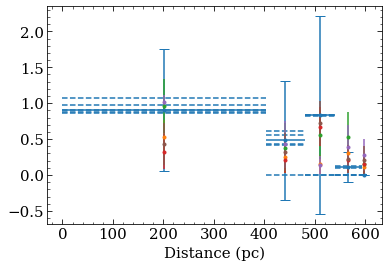

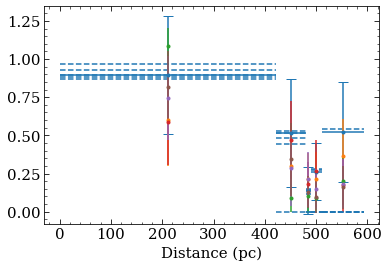

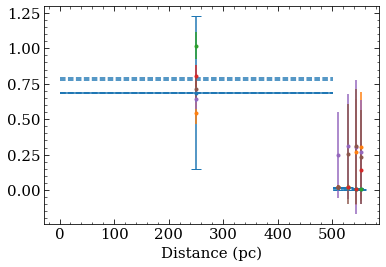

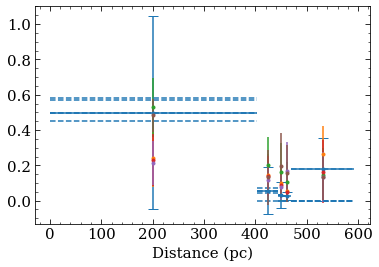

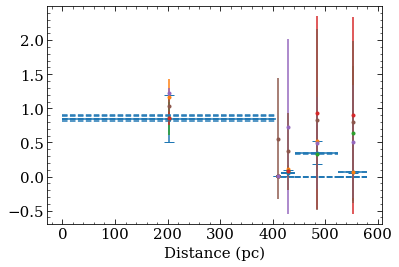

In [38]:


for i in range(len(sightlines)):
    fig, ax = plt.subplots()
    sl_i = sightlines[i]

    ax.hlines(sl_i.voxel_dAVdd, sl_i.bins[:-1], sl_i.bins[1:])
    ax.errorbar((sl_i.bins[:-1] + sl_i.bins[1:])/2, sl_i.voxel_dAVdd, yerr = sl_i.voxel_dAVdd_std * 10, capsize = 5, fmt = '.')
    for j in range(len(sl_i.stars)):
        ax.hlines(sl_i.dAVdd[j,:], sl_i.bins[:-1], sl_i.bins[1:], linestyle = 'dashed')
        ax.errorbar((sl_i.bins[:-1] + sl_i.bins[1:])/2, sl_i.dAVddd_derived[j,:], yerr = sl_i.dAVdd_derived_err[j, :], fmt = '.', color = 'C{}'.format(j+1))

    ax.set_xlabel('Distance (pc)')
    ax.set_label('$dA(V)/dd$ (mag/pc)')

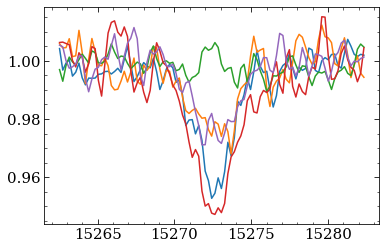

In [39]:
fig, ax = plt.subplots()
sl = sightlines[0]
for i in range(len(sl.signals)):
    ax.plot(wavs_window, sl.signals[i, :], color = 'C{}'.format(i))
    # ax.plot(wavs_window, sl.signals_aspcap[i, :], color = 'C{}'.format(i), linestyle = 'dashed')

plt.show()

In [40]:
# sightlines[0]

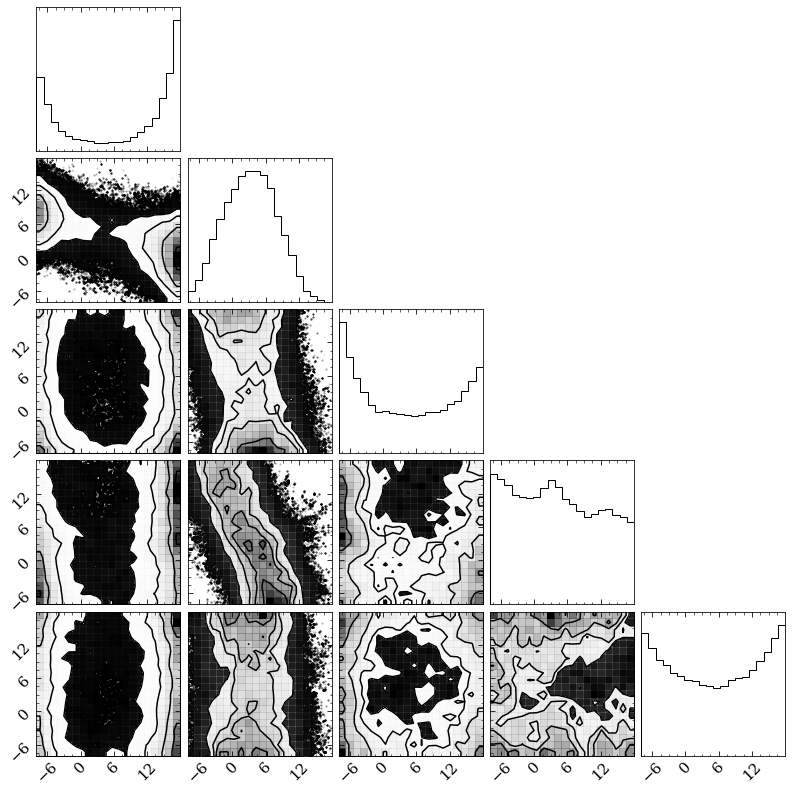

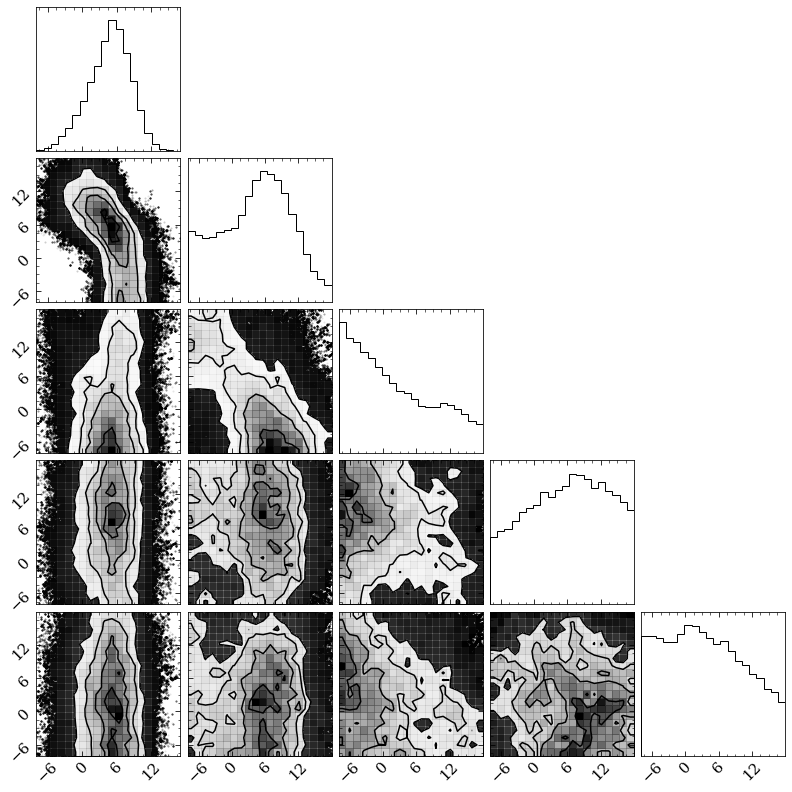

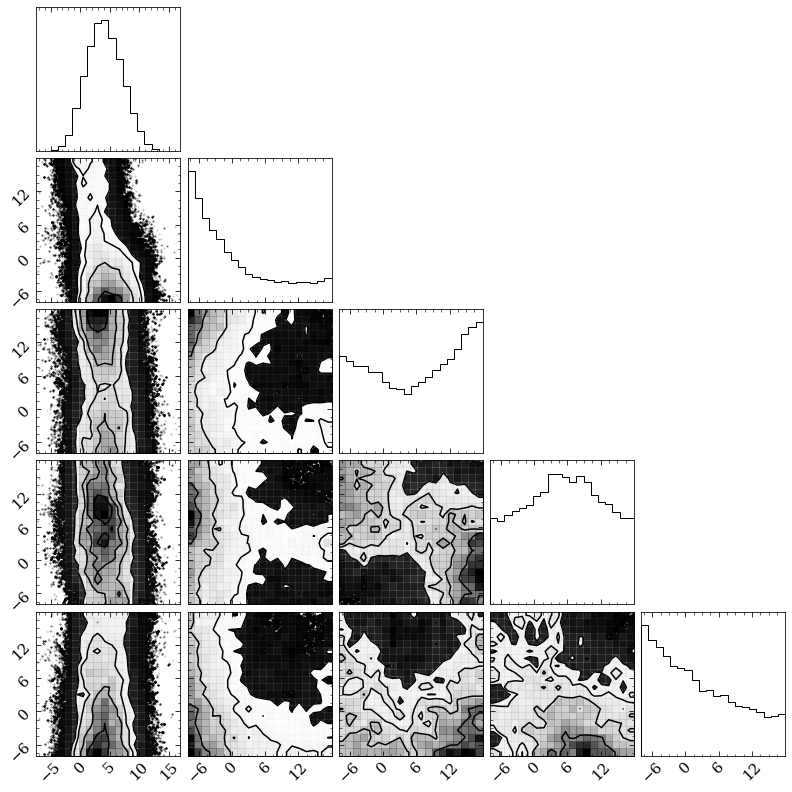

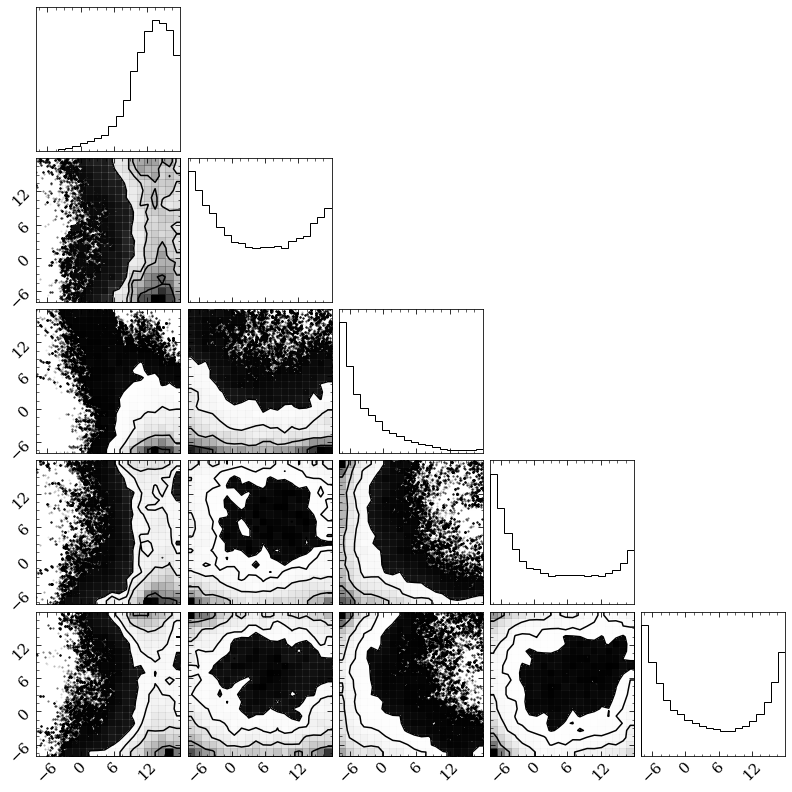

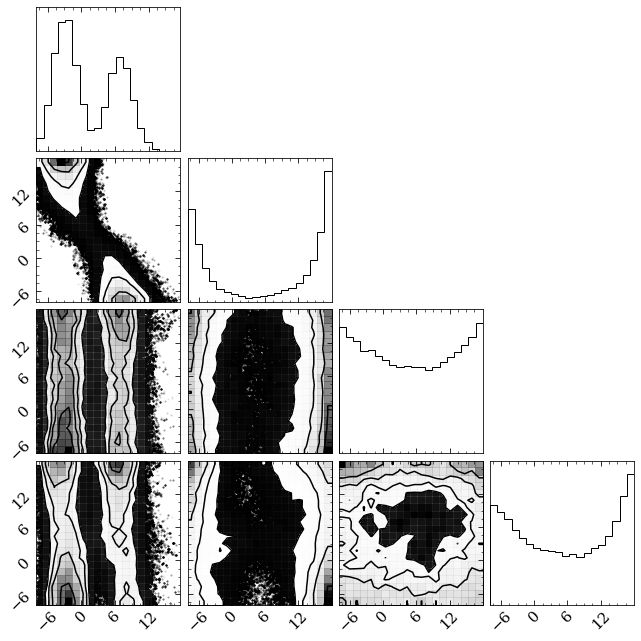

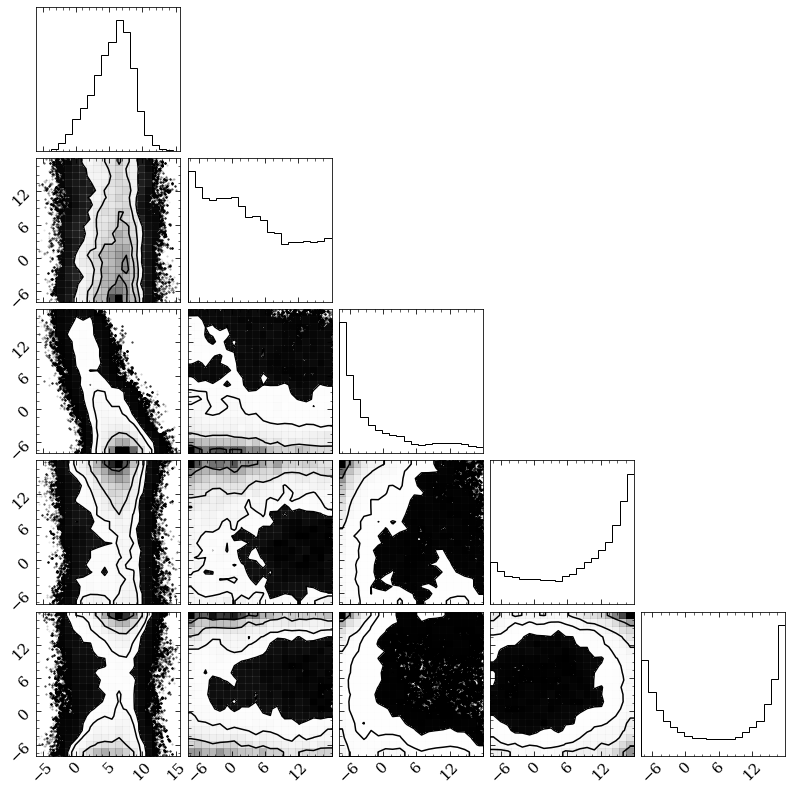

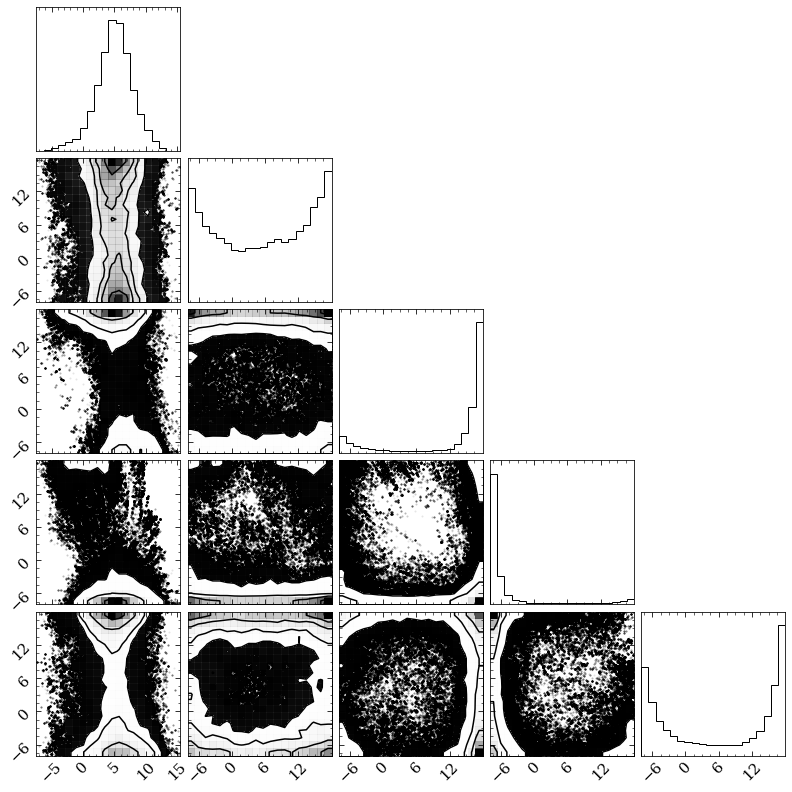

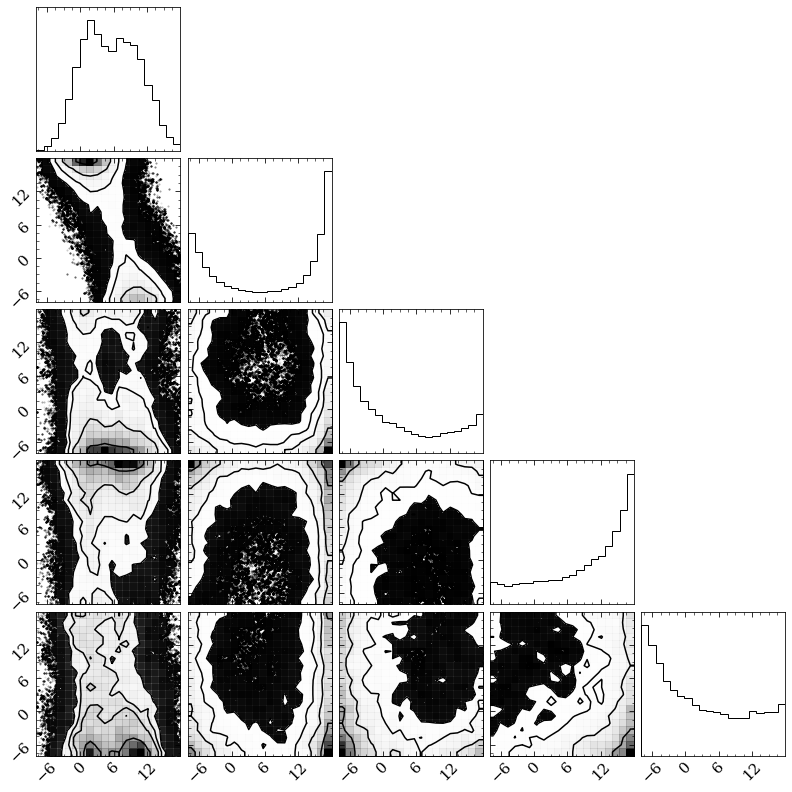

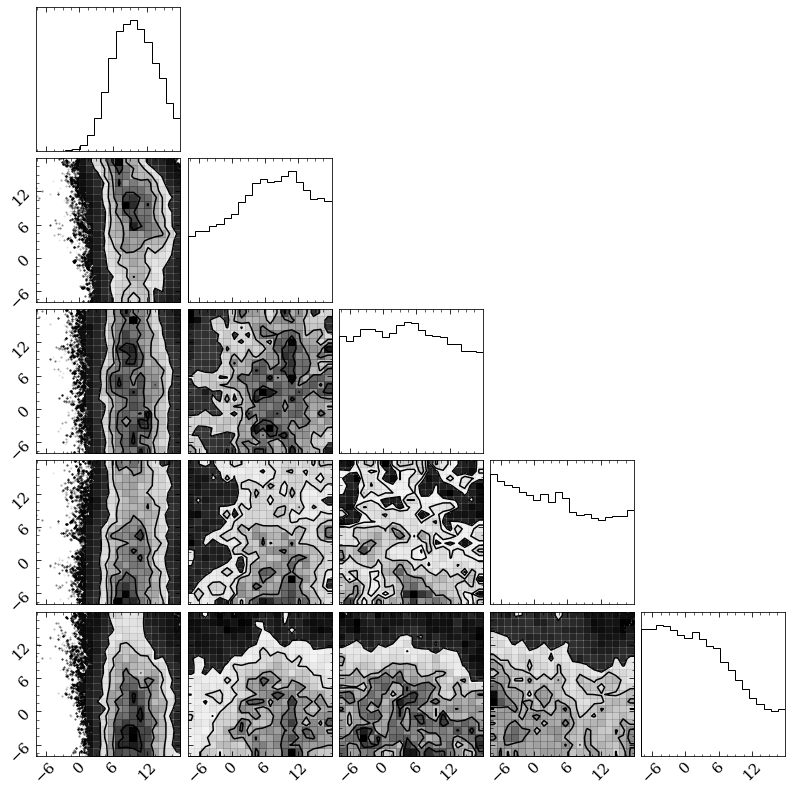

In [41]:
def make_corner(sampler, labels, minval = 50):
    dim = sampler.chain.shape[-1]
    samples = sampler.chain[:, minval:, :].reshape((-1, dim))
    # print(samples)
    fig = corner.corner(samples, figsize = (20, 20), labels = labels)
    # for ax in fig.axes:
        # ax.set_xlim(-15, 15)
        # ax.set_ylim(-15, 15) 
    plt.show()

def make_corner_vonly(sampler, ndim, labels, minval = 900):
    samples = sampler.chain[:, minval:, :ndim].reshape((-1, ndim))
    # print(samples)
    fig = corner.corner(samples, figsize = (20, 20), labels = labels)
    # for ax in fig.axes:
        # ax.set_xlim(-15, 15)
        # ax.set_ylim(-15, 15) 
    plt.show()

if True:
    for i in range(0, len(sightlines), 2):
        sl_i = sightlines[i]
        ndim = len(sl_i.bins) - 1 
        make_corner_vonly(sl_i.sampler, ndim, labels = None)

In [42]:
sightlines[0].sampler.chain.shape

(500, 5000, 30)

(5, 95) (5, 5, 95) (5, 5)


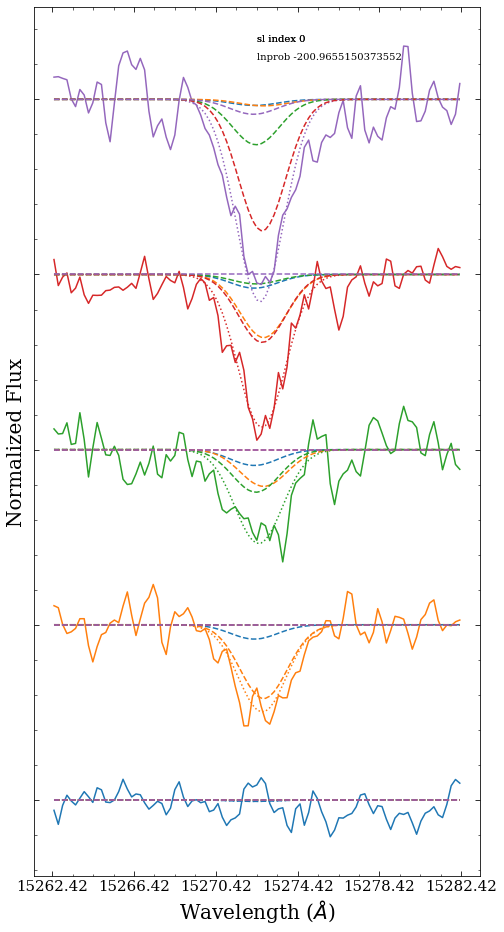

(5, 95) (5, 5, 95) (5, 5)


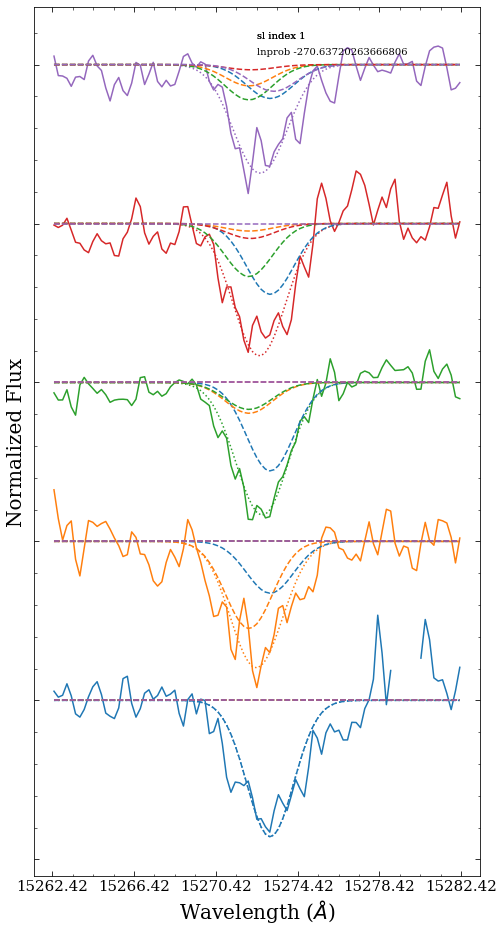

(5, 95) (5, 5, 95) (5, 5)


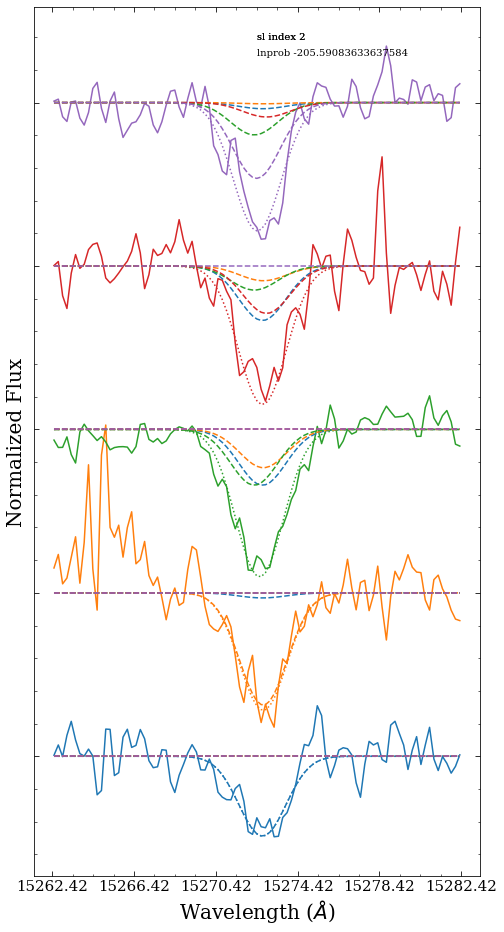

(5, 95) (5, 5, 95) (5, 5)


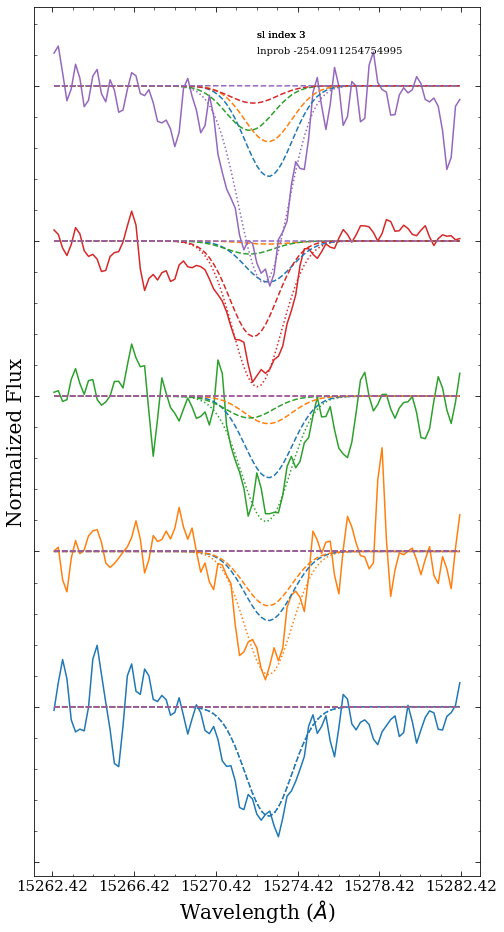

(5, 95) (5, 5, 95) (5, 5)


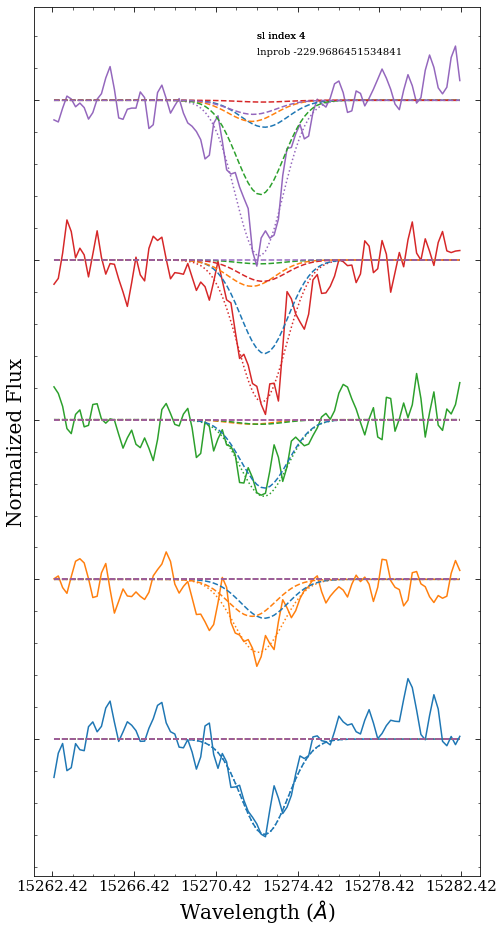

(5, 95) (5, 5, 95) (5, 5)


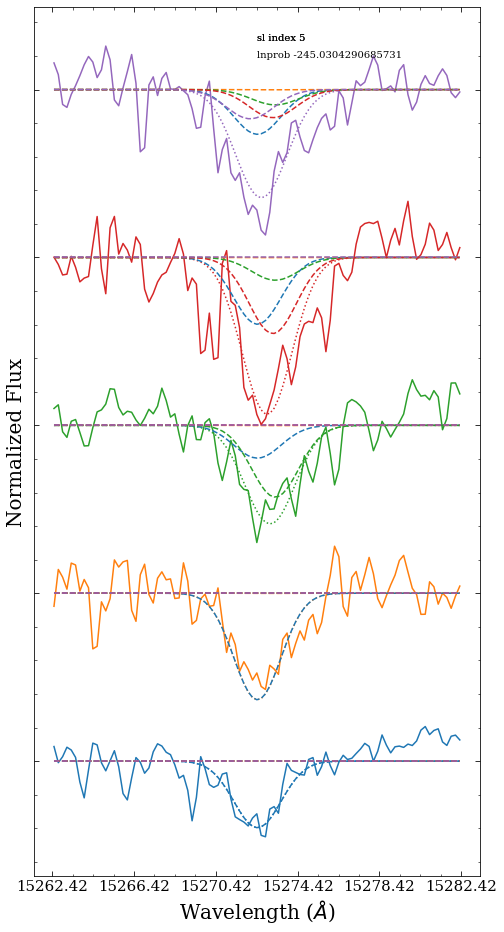

(5, 95) (5, 5, 95) (5, 5)


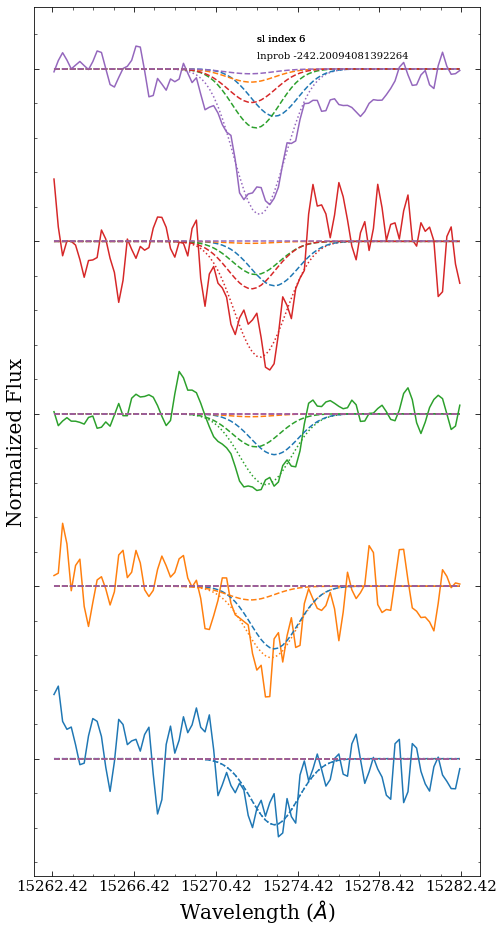

(5, 95) (5, 4, 95) (5, 4)


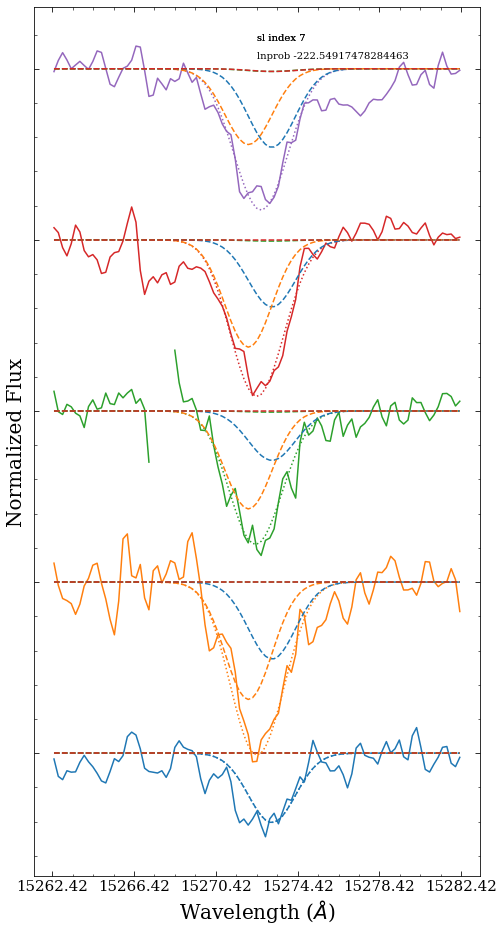

(5, 95) (5, 4, 95) (5, 4)


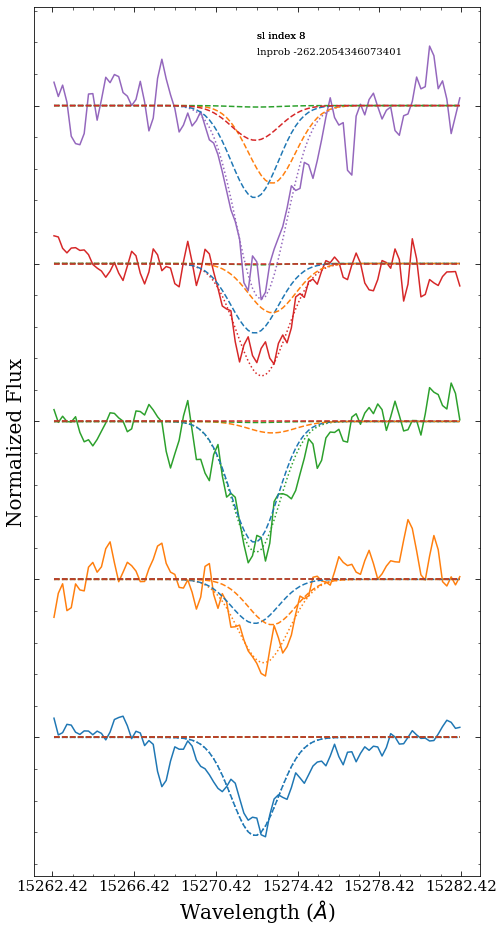

(5, 95) (5, 5, 95) (5, 5)


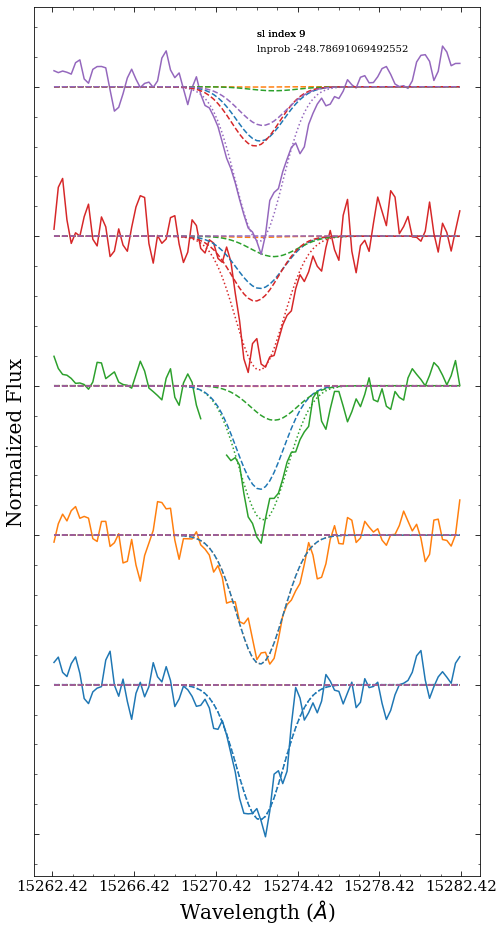

(5, 95) (5, 5, 95) (5, 5)


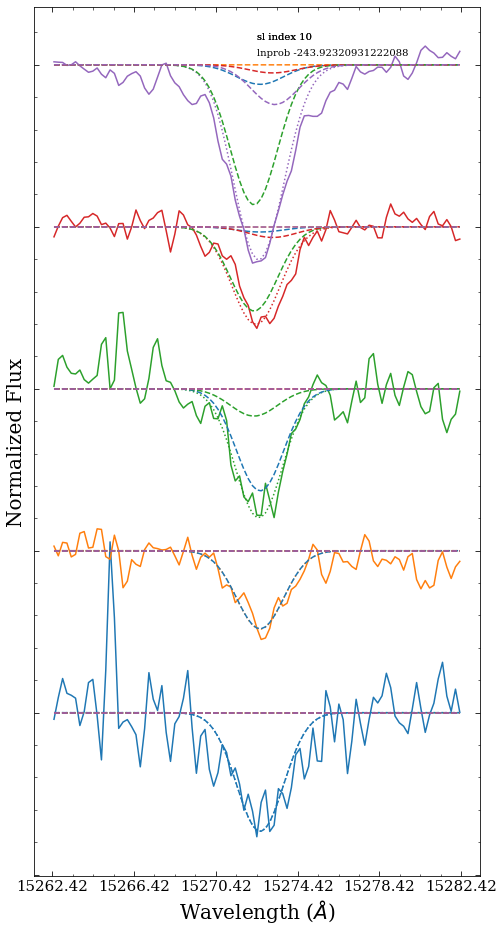

(5, 95) (5, 5, 95) (5, 5)


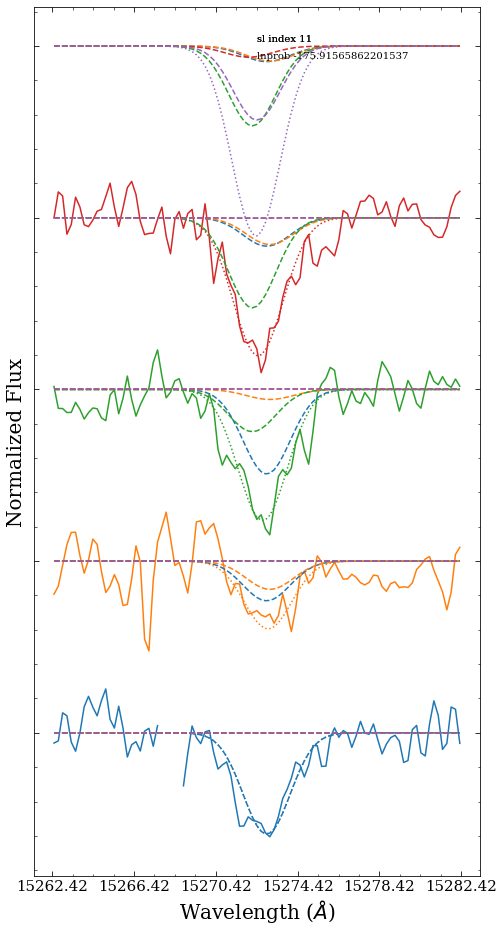

(5, 95) (5, 5, 95) (5, 5)


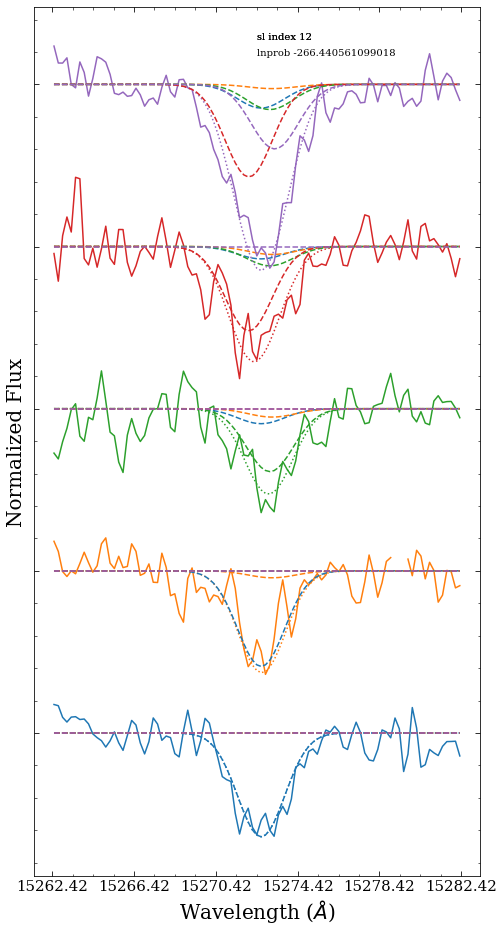

(5, 95) (5, 5, 95) (5, 5)


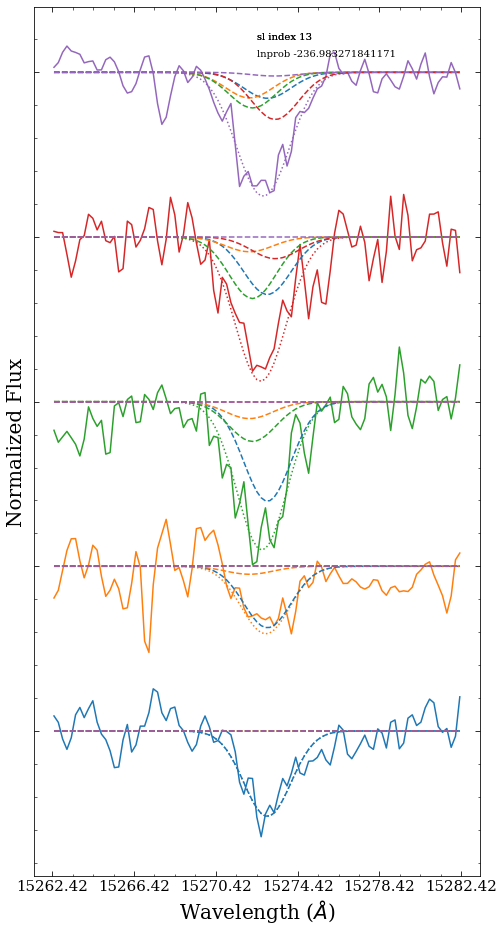

(5, 95) (5, 5, 95) (5, 5)


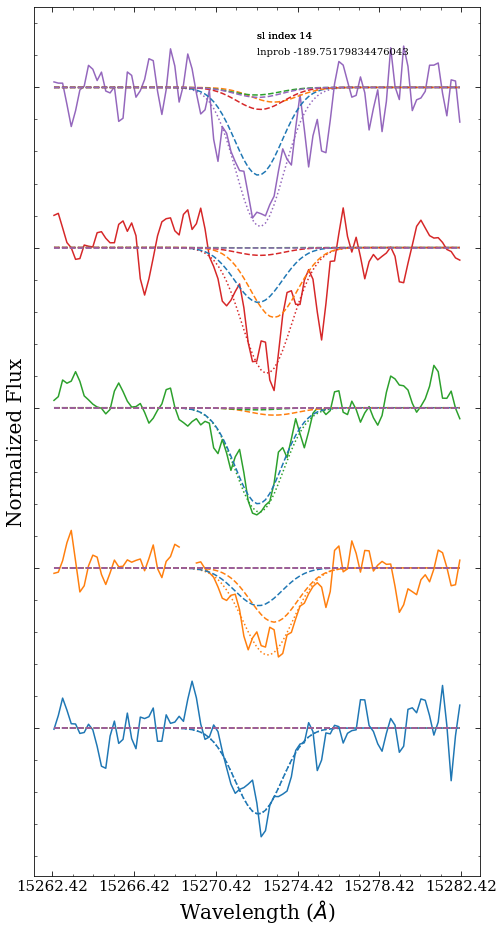

(5, 95) (5, 5, 95) (5, 5)


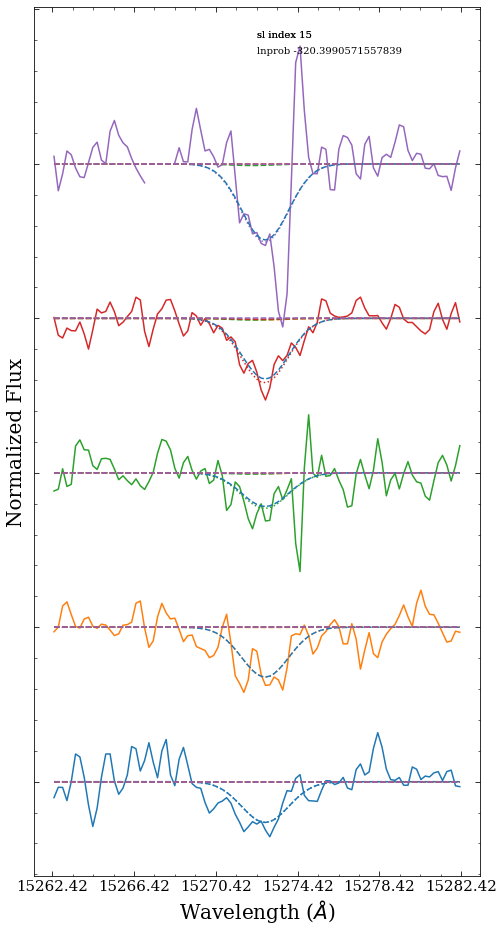

(5, 95) (5, 5, 95) (5, 5)


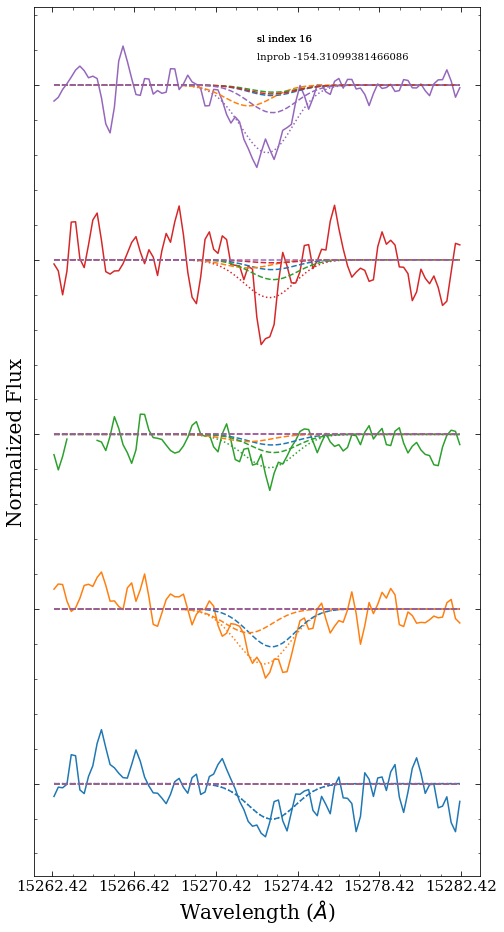

(5, 95) (5, 5, 95) (5, 5)


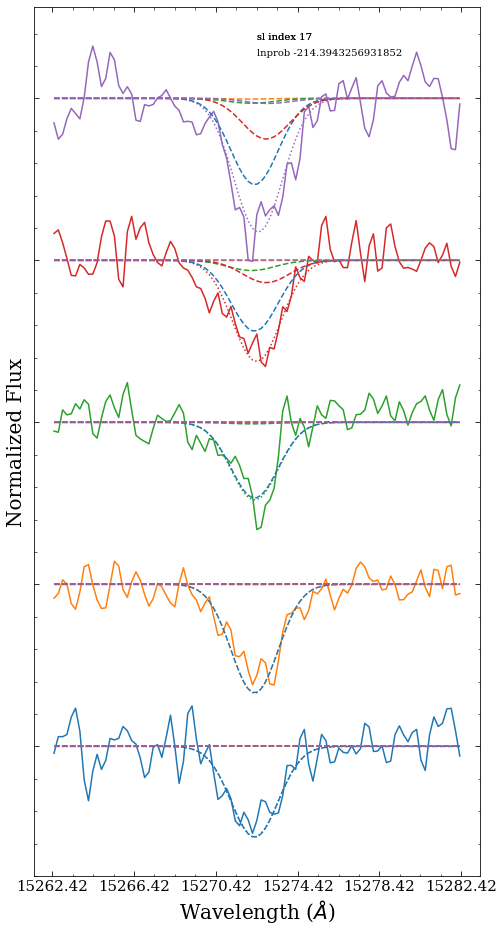

In [53]:
def model_signals_thing(rvelo, sl, dAVdd):
    # dAVdd = sl.dAVdd
    signals = np.zeros((len(sl.stars), len(wavs_window)))
    unsummed_signals = np.zeros((len(sl.stars), len(sl.bins)-1,len(wavs_window)))
    print(signals.shape, unsummed_signals.shape, sl.dAVdd.shape)
    peak_wavelength = dopplershift(rvelo)
    wavs_grid = np.tile(wavs_window, (len(sl.bins) - 1, 1))
    voxel_DIB_unscaled = np.exp(-(wavs_grid - peak_wavelength[:, np.newaxis])**2 / (2 * sigma0**2))
    amp = Differential_Amplitude(dAVdd, sl.bins[1:]-sl.bins[:-1])

    def single_signal(amp, bindex):
        amp[bindex:] = 0 # THIS MIGHT NEED TO BE -1
        # print(amp)

        voxel_DIB_scaled = -voxel_DIB_unscaled *  amp[:, np.newaxis] 
        summed_DIB = np.sum(voxel_DIB_scaled, axis = 0)
        # continuum = lambda x, m, b : m * (x - lambda0) + b
        # cont = continuum(wavs_window, 0, b)
        return summed_DIB  + 1, voxel_DIB_scaled 


    for i in range(len(sl.stars)):
        star = sl.stars[i]
        dAVdd_star = dAVdd[i, :]
        # amp = Differential_Amplitude(dAVdd_star, self.bins[1:]-self.bins[:-1])
        amp = Differential_Amplitude(dAVdd_star, 1)

        bin_index = sl.bin_inds[i]
        # signals[i, :] = single_signal(bin_index)
        signals[i, :], unsummed_signals[i, :, :] = single_signal(amp, bin_index)

    return signals, unsummed_signals

def plot_DIBS_thing(sampler, sl = sl, plot_objs = None):
    if plot_objs == None:
        fig, ax = plt.subplots(figsize = (8, 16))
    else:
        fig, ax = plot_objs
    # ax.plot(wavs_window, dstack1, label = '300-480 pc')
    # ax.plot(wavs_window, dstack2, label = '480-800 pc')
    ndim = len(sl.voxel_dAVdd)
    nstars = len(sl.stars)

    samples = sampler.chain[:, :, :].reshape((-1, sampler.chain.shape[-1]))

    medians = np.nanmedian(samples[-100:, :], axis = 0)

    # med_dAV_dd = np.nanmedian(samples[50:, :], axis = 0)

    # print(medians)
    med_velo = medians[:ndim]

    med_dAV_dd = medians[ndim:].reshape(-1, ndim)
    # med_dAV_dd = np.tile(med_dAV_dd, len(sl.stars)).reshape(len(sl.stars), -1)

    order_inds = np.array(np.argsort(sl.stars['DIST']))
    # print(order_inds)

    signal_recreated, signal_recreated_unsummed = model_signals_thing(med_velo, sl, med_dAV_dd) 
    # print('sru shape ', signal_recreated_unsummed.shape)
    # for i in range(len(sl.voxel_dAVdd)):
    for i in range(len(order_inds)):
        ii = order_inds[i]
        # signal_recreated_here = sl.model_signals(med_velo[i], dAVdd = med_dAV_dd[i, :])
        ax.plot(wavs_window, sl.signals[ii, :] + 0.05 * i, color = 'C{}'.format(i))
        ax.plot(wavs_window, signal_recreated[ii, :] + 0.05 * i , color = 'C{}'.format(i), linestyle = 'dotted',)# label = 'recreated signal')

        for j in range(len(sl.bins)-1):
            ax.plot(wavs_window, signal_recreated_unsummed[ii, j, : ] + 1 + 0.05 * i, color='C{}'.format(j), linestyle = 'dashed', alpha = 1)

    ax.legend(loc = 'lower left', fontsize = 20)

    ax.set_xlabel('Wavelength ($\AA$)', fontsize = 20)
    ax.set_ylabel('Normalized Flux', fontsize = 20)
    fig.set_facecolor('white')

    ax.set_xticks(np.arange(lambda0-10, lambda0 + 12, 4))
    ax.set_yticklabels('')

def plot_DIBS_freeze(sampler, sl = sl, plot_objs = None):
    if plot_objs == None:
        fig, ax = plt.subplots(figsize = (8, 16))
    else:
        fig, ax = plot_objs
    # ax.plot(wavs_window, dstack1, label = '300-480 pc')
    # ax.plot(wavs_window, dstack2, label = '480-800 pc')
    ndim = len(sl.voxel_dAVdd)
    nstars = len(sl.stars)

    samples = sampler.chain[:, 50:, :].reshape((-1, sampler.chain.shape[-1]))

    medians = np.nanmedian(samples[50:, :], axis = 0)

    # med_dAV_dd = np.nanmedian(samples[50:, :], axis = 0)

    # print(medians)
    med_velo = medians[:ndim]

    med_dAV_dd = medians[ndim:].reshape(-1, ndim)
    # med_dAV_dd = np.tile(med_dAV_dd, len(sl.stars)).reshape(len(sl.stars), -1)

    order_inds = np.array(np.argsort(sl.stars['DIST']))
    # print(order_inds)

    signal_recreated, signal_recreated_unsummed = model_signals_thing(med_velo, sl, med_dAV_dd) 
    # print('sru shape ', signal_recreated_unsummed.shape)
    # for i in range(len(sl.voxel_dAVdd)):
    for i in range(len(order_inds)):
        ii = order_inds[i]
        # signal_recreated_here = sl.model_signals(med_velo[i], dAVdd = med_dAV_dd[i, :])
        ax.plot(wavs_window, sl.signals[ii, :] + 0.05 * i, color = 'C{}'.format(i))
        ax.plot(wavs_window, signal_recreated[ii, :] + 0.05 * i , color = 'C{}'.format(i), linestyle = 'dotted',)# label = 'recreated signal')

        for j in range(len(sl.bins)-1):
            ax.plot(wavs_window, signal_recreated_unsummed[ii, j, : ] + 1 + 0.05 * i, color='C{}'.format(j), linestyle = 'dashed', alpha = 1)

    ax.legend(loc = 'lower left', fontsize = 20)

    ax.set_xlabel('Wavelength ($\AA$)', fontsize = 20)
    ax.set_ylabel('Normalized Flux', fontsize = 20)
    fig.set_facecolor('white')

    ax.set_xticks(np.arange(lambda0-10, lambda0 + 12, 4))
    ax.set_yticklabels('')

for i in range(len(sightlines)):
    fig, ax = plt.subplots(figsize = (8, 16))

    sl_i = sightlines[i]
    sampler_i = sl_i.sampler
    plot_DIBS_thing(sampler_i, sl = sl_i, plot_objs = (fig, ax))
    ymin, ymax = ax.get_ylim()
    ax.text(lambda0, ymax - .01, 'sl index {}'.format(i) )

    lp_i = sampler_i.lnprobability
    lp_med_i = np.nanmedian(lp_i[:, -100:])
    ax.text(lambda0, ymax - .01, 'sl index {}'.format(i) )
    ax.text(lambda0, ymax - .015, 'lnprob {}'.format(lp_med_i) )



    plt.show()


In [54]:
def plot_velo(sampler, sl  = sl, min_walker = None, plot_objs = None, color = None):
    if plot_objs == None:
        fig, ax = plt.subplots(figsize = (8,6))
    else:
        fig, ax = plot_objs
    # ax.plot(wavs_window, dstack1, label = '300-480 pc')
    # ax.plot(wavs_window, dstack2, label = '480-800 pc')
    ndim = len(sl.voxel_dAVdd)

    walker_max = sampler.chain.shape[1]

    if min_walker is None:
        min_walker_val = 50
    # else:
    min_walker_val = walker_max - min_walker

    samples = sampler.chain[:, min_walker_val:, :].reshape((-1, sampler.chain.shape[-1]))

    avg_av = np.nansum(np.median(sl.dAVdd, axis = 0))
    


    medians = np.nanmedian(samples[min_walker_val:, :], axis = 0)
    stdevs = np.nanstd(samples[min_walker_val:, :], ddof = 1, axis = 0)

    med_velo = medians[:ndim]
    std_velo = stdevs[:ndim]

    med_dAV_dd = medians[ndim:]
    med_dAV_dd = stdevs[ndim:]

    # med_dAV_dd = np.tile(med_dAV_dd, len(sl.stars)).reshape(len(sl.stars), -1)


    # ax.scatter((a.bins[1:] + a.bins[:-1] ) /2 , med_velo)
    # for i in range(len(sl.bins)-1): 
    #     ax.hlines(med_velo[i], sl.bins[i], sl.bins[i+1], linestyle = 'dashed')
    #     if i < len(sl.bins) -2:
    #         ax.vlines(sl.bins[i+1], med_velo[i], med_velo[i+1], linestyle = 'dashed')

    if color == None:
        color_choice = 'k'
    else:
        color_choice = color
    ax.errorbar((sl.bins[1:] + sl.bins[:-1] ) /2 , med_velo, yerr = std_velo, fmt = '.', color = color_choice, capsize = 5)
    ax.scatter((sl.bins[1:] + sl.bins[:-1] ) /2 , med_velo, c = color_choice)
    # ax.errorbar((sl.bins[1:]),med_velo, xerr = (sl.bins[1:] - sl.bins[:-1], np.zeros(med_velo.shape)), yerr = std_velo, fmt = '.' )
    ax.set_xlim(350, 600)
    ax.set_xlabel('Distance (pc)')
    ax.set_ylabel('Radial Velocity (km/s)')

    dist_xx = (sl.bins[1:] + sl.bins[:-1] ) /2
    # med_velo

    return fig, ax, dist_xx, med_velo, std_velo


In [45]:
(sl_i.bins[1:] - sl_i.bins[:-1])

array([405.7369  ,  10.01001 ,  25.987366,  83.24588 ,  54.006287],
      dtype=float32)

In [46]:
avs = np.zeros(len(sightlines))
for i in range(len(sightlines)):
    sl_i = sightlines[i]
    avs[i] = np.sum(sl_i.voxel_dAVdd)

cnorm = matplotlib.colors.Normalize(np.min(avs), np.max(avs))
cmap = plt.get_cmap('viridis')
mappable = matplotlib.cm.ScalarMappable(norm = cnorm,  cmap = cmap)


/uufs/chpc.utah.edu/sys/installdir/r8/python/3.10.3/lib/python3.10/site-packages/scipy-1.8.0-py3.10-linux-x86_64.egg/scipy/optimize/_minpack_py.py:756: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma
/uufs/chpc.utah.edu/sys/installdir/r8/python/3.10.3/lib/python3.10/site-packages/scipy-1.8.0-py3.10-linux-x86_64.egg/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


(array([1., 1.]), array([[inf, inf],
       [inf, inf]]))


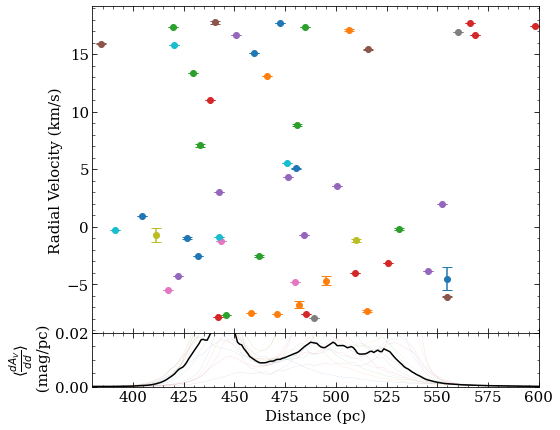

In [59]:
from scipy.optimize import curve_fit
line = lambda x, m, b : m * x + b

sl_davdd = np.zeros((len(l_sample.flatten()), edenhofer.shape[-1]))
for i in range(len(l_sample.flatten())): 
    l_i, b_i = l_sample.flatten()[i], b_sample.flatten()[i]
    l_ind, b_ind = find_nearest(l_i, b_i)
    sl_davdd[i, :] = np.copy(edenhofer[b_ind, l_ind, :])


fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (8,7), sharex = True, gridspec_kw={'height_ratios': [6,1], 'hspace': 0})


dist_xx = np.array([])
velo_yy = np.array([])
std_velo = np.array([])
# for i in range(22, len(sightlines), 1):
for i in range(N_filament):

    sl_i = sightlines[i]
    sampler_i = sl_i.sampler
    color = cmap(cnorm(avs[i]))
    color = 'C'+str(i)
    _, __, dist_xx_i, velo_yy_i, std_velo_i = plot_velo(sampler_i, sl = sl_i, min_walker = 10, plot_objs = (fig, axs[0]), color = color)
    dist_xx = np.concatenate([dist_xx, dist_xx_i])
    velo_yy = np.concatenate([velo_yy, velo_yy_i])
    std_velo = np.concatenate([std_velo, std_velo_i])
    axs[1].plot(distance, sl_davdd[i, :], linestyle = 'dashed', linewidth = .1, color = 'C{}'.format(i))

dist_sort = np.argsort(dist_xx)


fit_result = curve_fit(line, dist_xx[dist_sort], velo_yy[dist_sort], sigma = std_velo[dist_sort])
print(fit_result)
fit_params = fit_result[0]
fit_result_err = np.sqrt(np.diag(fit_result[1]))
xx_plot = np.linspace(380, 600)

# axs[0].plot(xx_plot, line(xx_plot, fit_params[0], fit_params[1]))

# axs[0].fill_between(xx_plot, line(xx_plot, fit_params[0] + fit_result_err[0], fit_params[1] + fit_result_err[1]),
#                     line(xx_plot, fit_params[0] - fit_result_err[0], fit_params[1] - fit_result_err[1]), alpha = 0.1, color = 'C0')

# ymin, ymax = ax.get_ylim()
axs[1].plot(distance, np.nanmedian(sl_davdd[:N_filament, :], axis = 0), color = 'k')
# ax.set_ylim(ymin, ymax)
axs[1].set_ylim(0, 0.02)
axs[1].set_xlim(380, 600)
axs[1].set_xlabel('Distance (pc)')
axs[1].set_ylabel(r'$ \langle \frac{dA_V}{dd} \rangle $' + '\n (mag/pc)')
fig.set_facecolor('white')
# fig.colorbar(mappable, ax = axs[0], label = 'Sightline A(V) (mag)')

# plt.savefig('output_sightlines_{}.png'.format(name), pad_inches = 0.3)
plt.show()

In [58]:
print(velo_yy)

[-3.6802371   7.29019572 -0.94816306  5.0691199  -4.49986998 13.00900972
 -7.46309412 -7.54976447 -6.77615499 17.09700181  5.25911298  7.06621754
 -2.51039836  8.84589861 -0.19817157 11.40935066 10.98893139 -7.60642229
 -3.11125171 16.68095775  8.09147692 -4.30591647  3.05745437  4.29235488
 -3.81432079  0.68532762 15.91354834 17.74849662 15.40328667 -6.06918738
 17.06929764 -5.48187981 -1.24739487 -4.77906034 -6.62673735 14.62894591
 -7.90717938 16.92048973 15.57645853 -1.43944917 13.35246793 -0.73142359
 -1.19131632  3.1145504  -0.28228874 15.80561198 -0.9083668   5.54385778
  3.18409983  0.91389838 -2.53182572 15.05265798 17.68334591  9.26715985
 13.08217283 -4.687321   -7.31127213 -0.28515252  3.76172155 17.35965758
 13.38750569 -7.65866319 17.32349072 10.37217033 -7.84689713 -4.0443955
 17.72739021 17.46479278  1.68410707 16.67308527 -0.70361575  3.5146373
  1.97223447]


(15,)
(array([1., 1.]), array([[inf, inf],
       [inf, inf]]))


/uufs/chpc.utah.edu/sys/installdir/r8/python/3.10.3/lib/python3.10/site-packages/scipy-1.8.0-py3.10-linux-x86_64.egg/scipy/optimize/_minpack_py.py:756: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma
/uufs/chpc.utah.edu/sys/installdir/r8/python/3.10.3/lib/python3.10/site-packages/scipy-1.8.0-py3.10-linux-x86_64.egg/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


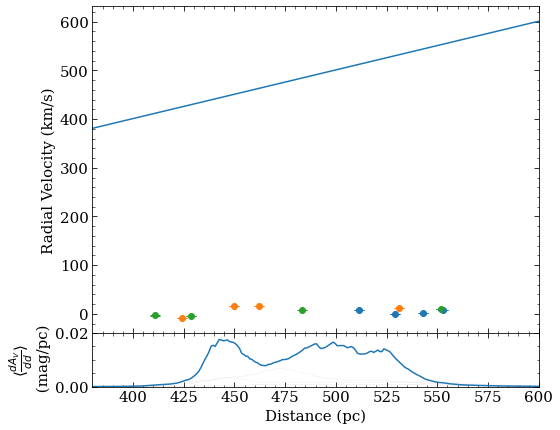

In [48]:
fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (8,7), sharex = True, gridspec_kw={'height_ratios': [6,1], 'hspace': 0})


dist_xx = np.array([])
velo_yy = np.array([])
std_velo = np.array([])
for i in range(N_filament, len(sightlines), 1):
    sl_i = sightlines[i]
    sampler_i = sl_i.sampler
    color = cmap(cnorm(avs[i]))
    color = 'C'+str(i - N_filament) 
    _, __, dist_xx_i, velo_yy_i, std_velo_i = plot_velo(sampler_i, sl = sl_i, min_walker = 10, plot_objs = (fig, axs[0]), color = color)
    dist_xx = np.concatenate([dist_xx, dist_xx_i])
    velo_yy = np.concatenate([velo_yy, velo_yy_i])
    std_velo = np.concatenate([std_velo, std_velo_i])
    axs[1].plot(distance, sl_davdd[i, :], linestyle = 'dashed', linewidth = .1, color = 'C{}'.format(i))


print(dist_xx.shape)
dist_sort = np.argsort(dist_xx)
# dist_sort = np.argsort(dist_xx)[:-8]


fit_result = curve_fit(line, dist_xx[dist_sort], velo_yy[dist_sort], sigma = std_velo[dist_sort])
print(fit_result)
fit_params = fit_result[0]
fit_result_err = np.sqrt(np.diag(fit_result[1]))
xx_plot = np.linspace(380, 600)

axs[0].plot(xx_plot, line(xx_plot, fit_params[0], fit_params[1]))

# axs[0].fill_between(xx_plot, line(xx_plot, fit_params[0] + fit_result_err[0], fit_params[1] + fit_result_err[1]),
#                     line(xx_plot, fit_params[0] - fit_result_err[0], fit_params[1] - fit_result_err[1]), alpha = 0.1, color = 'C0')

# ymin, ymax = ax.get_ylim()
axs[1].plot(distance, np.nanmedian(sl_davdd[N_background:, :], axis = 0) )
axs[1].set_ylim(0, 0.02)

# ax.set_ylim(ymin, ymax)
axs[1].set_xlim(380, 600)
axs[1].set_xlabel('Distance (pc)')
axs[1].set_ylabel(r'$ \langle \frac{dA_V}{dd} \rangle $' + '\n (mag/pc)')
fig.set_facecolor('white')
# fig.colorbar(mappable, ax = axs[0], label = 'Sightline A(V) (mag)')

# plt.savefig('output_sightlines_{}.png'.format(name), pad_inches = 0.3)
plt.show()

In [49]:
dist_sort

array([ 5, 10,  0, 11,  6, 12,  7,  8, 13,  1,  2,  9,  3, 14,  4])

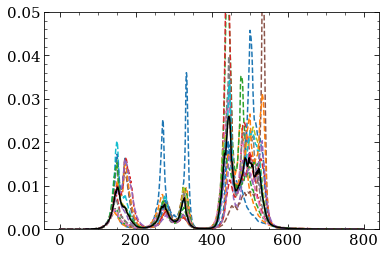

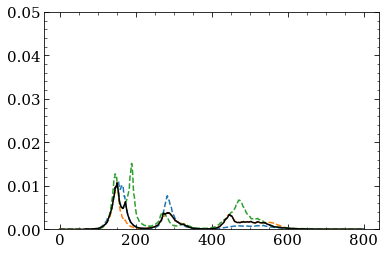

In [50]:
fig, ax = plt.subplots()
for i in range(N_filament):
    ax.plot(distance, sl_davdd[i, :], linestyle = 'dashed')
ax.plot(distance, np.nanmedian(sl_davdd[:N_filament, : ], axis = 0), color = 'k')
ax.set_ylim(0, 0.05)


plt.show()
fig, ax = plt.subplots()
for i in range(N_filament, N_filament + N_background, 1):
    ax.plot(distance, sl_davdd[i, :], linestyle = 'dashed')

ax.plot(distance, np.nanmedian(sl_davdd[N_filament:, : ], axis = 0), color = 'k')
ax.set_ylim(0, 0.05)

plt.show()

[ 78.93037415 288.17993164 426.85144043 480.41622925 554.69116211]
[-3.6802371   7.29019572 -0.94816306  5.0691199  -4.49986998]
[426.85144043 480.41622925 554.69116211]
(array([  0.10486527, -45.52609605]), array([[ 1.33808500e-03, -6.14154358e-01],
       [-6.14154358e-01,  2.82845953e+02]]))


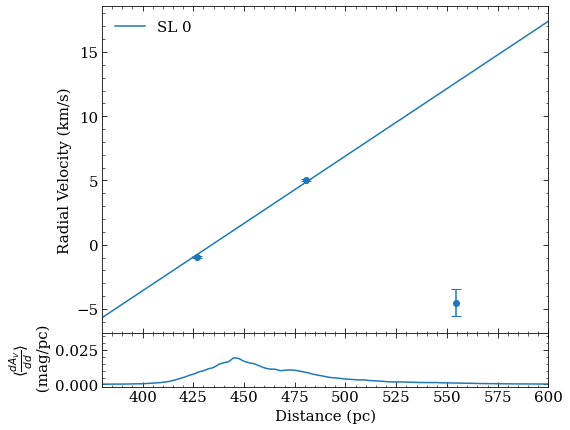

[225.25550842 457.98275757 470.74609375 481.76266479 506.38983154]
[13.00900972 -7.46309412 -7.54976447 -6.77615499 17.09700181]
[457.98275757 470.74609375 481.76266479 506.38983154]
(array([  0.04083125, -26.77081978]), array([[ 1.54834852e-02, -7.28876773e+00],
       [-7.28876773e+00,  3.43114868e+03]]))


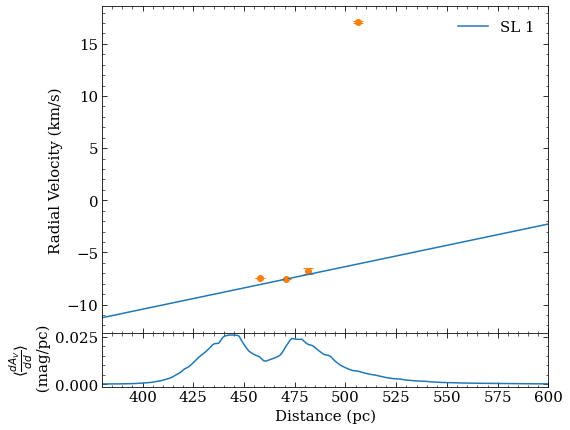

[209.13446045 433.10821533 461.99261475 481.04272461 530.97290039]
[ 5.25911298  7.06621754 -2.51039836  8.84589861 -0.19817157]
[433.10821533 461.99261475 481.04272461 530.97290039]
(array([-0.04632121, 24.95941155]), array([[ 6.38445061e-03, -3.13733700e+00],
       [-3.13733700e+00,  1.55029662e+03]]))


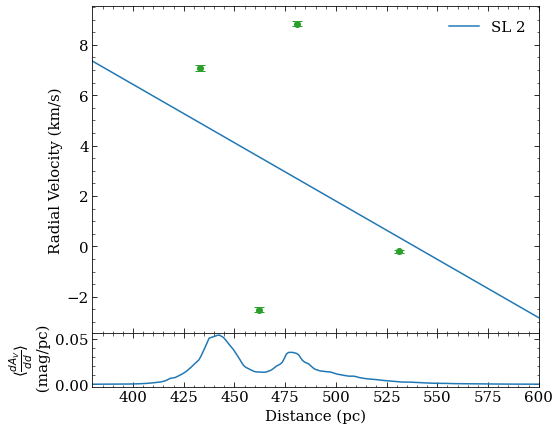

[197.89797974 438.05532837 485.31970215 525.91424561 568.609375  ]
[11.40935066 10.98893139 -7.60642229 -3.11125171 16.68095775]
[438.05532837 485.31970215 525.91424561 568.609375  ]
(array([-0.02367148,  9.12129305]), array([[ 1.53640196e-02, -7.90694946e+00],
       [-7.90694946e+00,  4.07796159e+03]]))


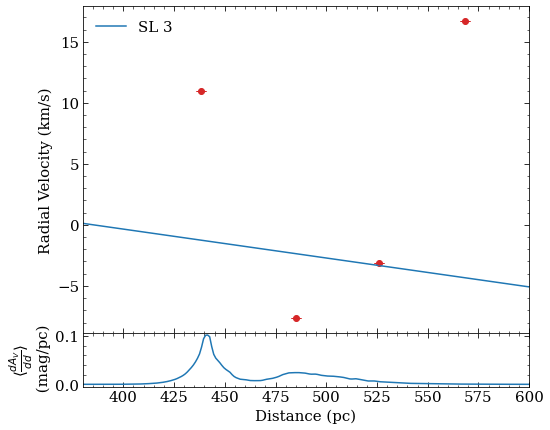

[203.15335083 421.97085571 442.64001465 476.16687012 545.49346924]
[ 8.09147692 -4.30591647  3.05745437  4.29235488 -3.81432079]
[421.97085571 442.64001465 476.16687012 545.49346924]
(array([1., 1.]), array([[inf, inf],
       [inf, inf]]))


/uufs/chpc.utah.edu/sys/installdir/r8/python/3.10.3/lib/python3.10/site-packages/scipy-1.8.0-py3.10-linux-x86_64.egg/scipy/optimize/_minpack_py.py:756: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma
/uufs/chpc.utah.edu/sys/installdir/r8/python/3.10.3/lib/python3.10/site-packages/scipy-1.8.0-py3.10-linux-x86_64.egg/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


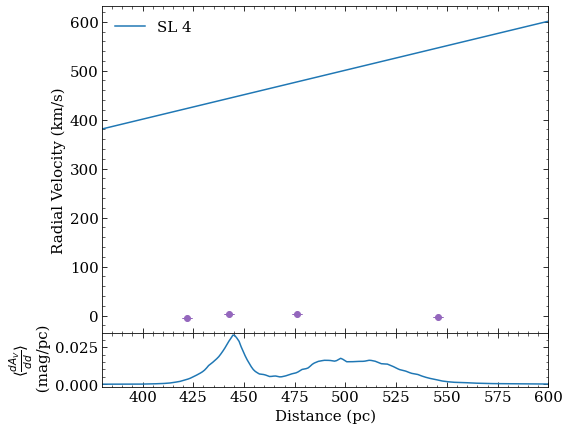

[189.54560852 384.10205078 440.43005371 515.91638184 554.87792969]
[ 0.68532762 15.91354834 17.74849662 15.40328667 -6.06918738]
[384.10205078 440.43005371 515.91638184 554.87792969]
(array([-1.07647570e-02,  2.01251225e+01]), array([[ 5.25042012e-04, -2.21033813e-01],
       [-2.21033813e-01,  9.49133232e+01]]))


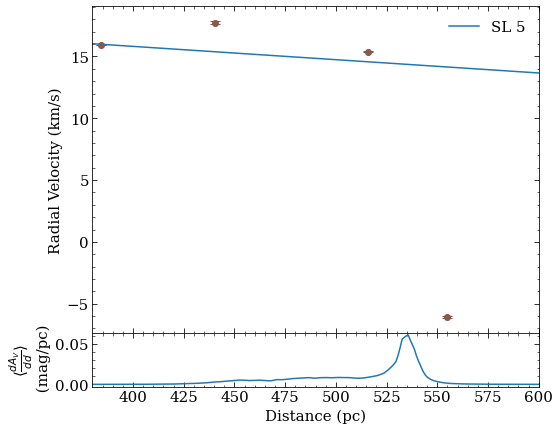

[206.06762695 417.14025879 443.22155762 479.97323608 602.42541504]
[17.06929764 -5.48187981 -1.24739487 -4.77906034 -6.62673735]
[417.14025879 443.22155762 479.97323608]
(array([1., 1.]), array([[inf, inf],
       [inf, inf]]))


/uufs/chpc.utah.edu/sys/installdir/r8/python/3.10.3/lib/python3.10/site-packages/scipy-1.8.0-py3.10-linux-x86_64.egg/scipy/optimize/_minpack_py.py:756: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma
/uufs/chpc.utah.edu/sys/installdir/r8/python/3.10.3/lib/python3.10/site-packages/scipy-1.8.0-py3.10-linux-x86_64.egg/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


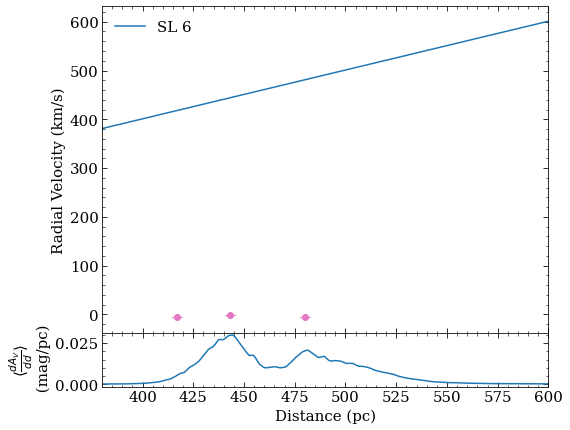

[211.53045654 489.09066772 560.12542725 637.1663208 ]
[14.62894591 -7.90717938 16.92048973 15.57645853]
[489.09066772 560.12542725]
(array([1., 1.]), array([[inf, inf],
       [inf, inf]]))


/uufs/chpc.utah.edu/sys/installdir/r8/python/3.10.3/lib/python3.10/site-packages/scipy-1.8.0-py3.10-linux-x86_64.egg/scipy/optimize/_minpack_py.py:756: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma
/uufs/chpc.utah.edu/sys/installdir/r8/python/3.10.3/lib/python3.10/site-packages/scipy-1.8.0-py3.10-linux-x86_64.egg/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


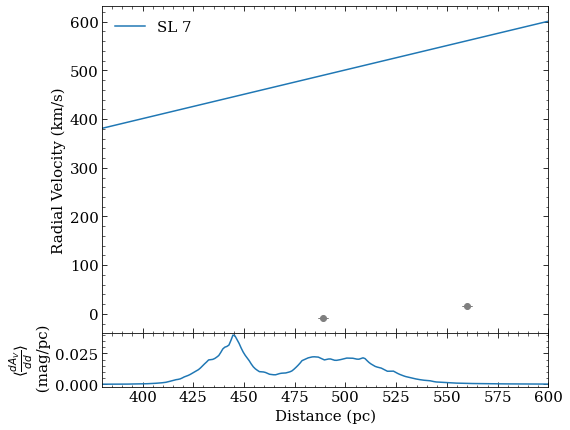

[125.85613251 329.00949097 411.31170654 509.96740723]
[-1.43944917 13.35246793 -0.73142359 -1.19131632]
[411.31170654 509.96740723]
(array([-0.00466159,  1.18594418]), array([[inf, inf],
       [inf, inf]]))


/uufs/chpc.utah.edu/sys/installdir/r8/python/3.10.3/lib/python3.10/site-packages/scipy-1.8.0-py3.10-linux-x86_64.egg/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


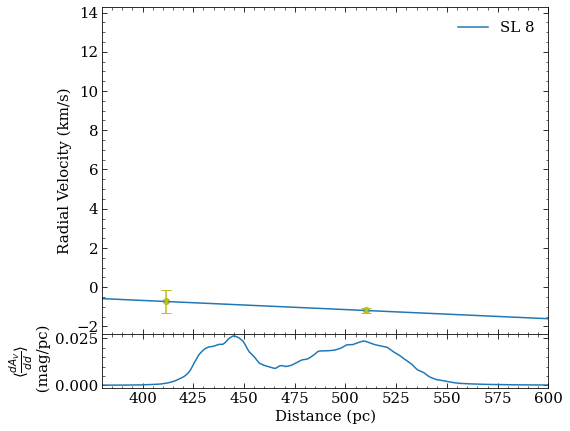

[187.08995056 391.30517578 420.15991211 442.50958252 476.16537476]
[ 3.1145504  -0.28228874 15.80561198 -0.9083668   5.54385778]
[391.30517578 420.15991211 442.50958252 476.16537476]
(array([1., 1.]), array([[inf, inf],
       [inf, inf]]))


/uufs/chpc.utah.edu/sys/installdir/r8/python/3.10.3/lib/python3.10/site-packages/scipy-1.8.0-py3.10-linux-x86_64.egg/scipy/optimize/_minpack_py.py:756: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma
/uufs/chpc.utah.edu/sys/installdir/r8/python/3.10.3/lib/python3.10/site-packages/scipy-1.8.0-py3.10-linux-x86_64.egg/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


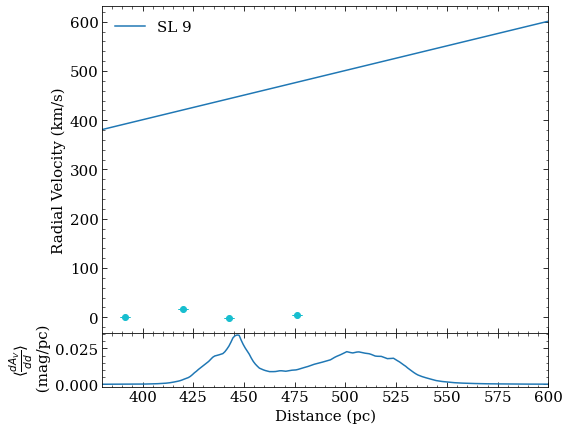

[199.62854004 404.26208496 431.84075928 459.41946411 472.32495117]
[ 3.18409983  0.91389838 -2.53182572 15.05265798 17.68334591]
[404.26208496 431.84075928 459.41946411 472.32495117]
(array([1., 1.]), array([[inf, inf],
       [inf, inf]]))


/uufs/chpc.utah.edu/sys/installdir/r8/python/3.10.3/lib/python3.10/site-packages/scipy-1.8.0-py3.10-linux-x86_64.egg/scipy/optimize/_minpack_py.py:756: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma
/uufs/chpc.utah.edu/sys/installdir/r8/python/3.10.3/lib/python3.10/site-packages/scipy-1.8.0-py3.10-linux-x86_64.egg/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


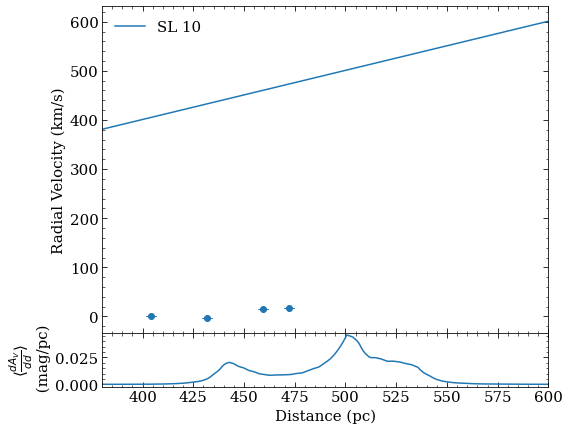

[226.2718811  466.19689941 495.03939819 515.23370361 721.83813477]
[ 9.26715985 13.08217283 -4.687321   -7.31127213 -0.28515252]
[466.19689941 495.03939819 515.23370361]
(array([ -0.41972833, 208.74528455]), array([[ 8.83829043e-04, -4.15787189e-01],
       [-4.15787189e-01,  1.95767614e+02]]))


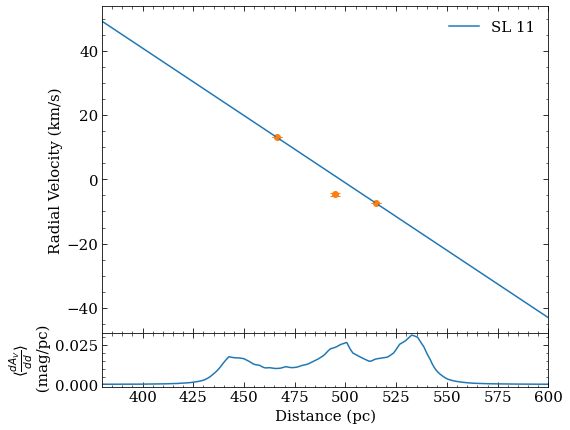

[207.3690033  419.74301147 429.75302124 445.83532715 484.90942383]
[ 3.76172155 17.35965758 13.38750569 -7.65866319 17.32349072]
[419.74301147 429.75302124 445.83532715 484.90942383]
(array([1., 1.]), array([[inf, inf],
       [inf, inf]]))


/uufs/chpc.utah.edu/sys/installdir/r8/python/3.10.3/lib/python3.10/site-packages/scipy-1.8.0-py3.10-linux-x86_64.egg/scipy/optimize/_minpack_py.py:756: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma
/uufs/chpc.utah.edu/sys/installdir/r8/python/3.10.3/lib/python3.10/site-packages/scipy-1.8.0-py3.10-linux-x86_64.egg/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


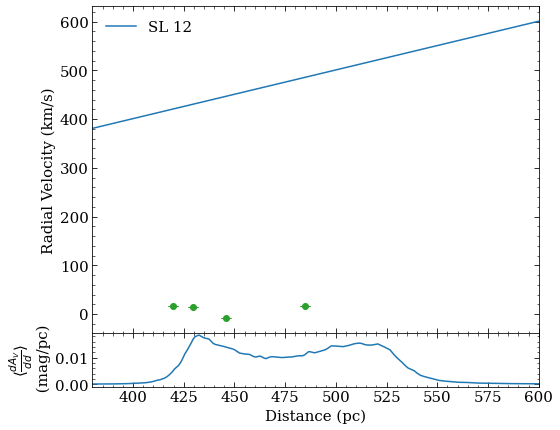

[202.04191589 441.96694946 509.50079346 566.07592773 598.00531006]
[10.37217033 -7.84689713 -4.0443955  17.72739021 17.46479278]
[441.96694946 509.50079346 566.07592773 598.00531006]
(array([1., 1.]), array([[inf, inf],
       [inf, inf]]))


/uufs/chpc.utah.edu/sys/installdir/r8/python/3.10.3/lib/python3.10/site-packages/scipy-1.8.0-py3.10-linux-x86_64.egg/scipy/optimize/_minpack_py.py:756: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma
/uufs/chpc.utah.edu/sys/installdir/r8/python/3.10.3/lib/python3.10/site-packages/scipy-1.8.0-py3.10-linux-x86_64.egg/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


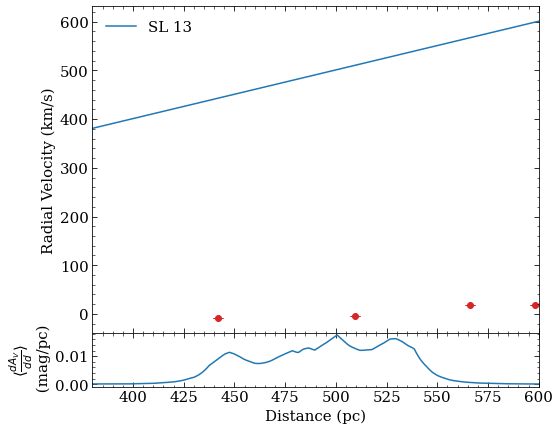

[211.19619751 450.85778809 484.32821655 500.39001465 552.22357178]
[ 1.68410707 16.67308527 -0.70361575  3.5146373   1.97223447]
[450.85778809 484.32821655 500.39001465 552.22357178]
(array([1., 1.]), array([[inf, inf],
       [inf, inf]]))


/uufs/chpc.utah.edu/sys/installdir/r8/python/3.10.3/lib/python3.10/site-packages/scipy-1.8.0-py3.10-linux-x86_64.egg/scipy/optimize/_minpack_py.py:756: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma
/uufs/chpc.utah.edu/sys/installdir/r8/python/3.10.3/lib/python3.10/site-packages/scipy-1.8.0-py3.10-linux-x86_64.egg/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


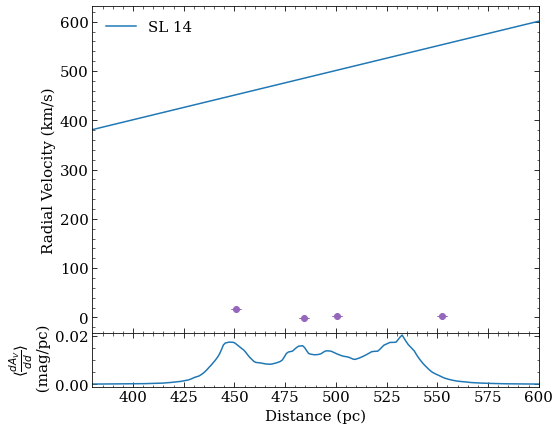

[250.89526367 511.32839966 529.37231445 542.88555908 552.89770508]
[ 7.84946609  6.8828972  -1.34626283  2.70056683  8.1739516 ]
[511.32839966 529.37231445 542.88555908 552.89770508]
(array([1., 1.]), array([[inf, inf],
       [inf, inf]]))


/uufs/chpc.utah.edu/sys/installdir/r8/python/3.10.3/lib/python3.10/site-packages/scipy-1.8.0-py3.10-linux-x86_64.egg/scipy/optimize/_minpack_py.py:756: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma
/uufs/chpc.utah.edu/sys/installdir/r8/python/3.10.3/lib/python3.10/site-packages/scipy-1.8.0-py3.10-linux-x86_64.egg/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


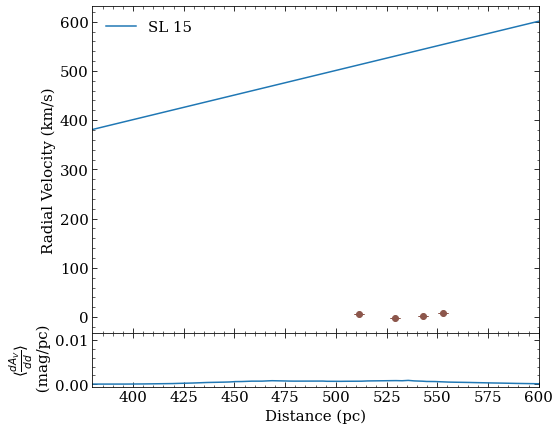

[201.60366821 423.92895508 449.6555481  461.94467163 530.94549561]
[15.93236829 -7.97368574 15.68507504 15.38491386 12.86331664]
[423.92895508 449.6555481  461.94467163 530.94549561]
(array([1., 1.]), array([[inf, inf],
       [inf, inf]]))


/uufs/chpc.utah.edu/sys/installdir/r8/python/3.10.3/lib/python3.10/site-packages/scipy-1.8.0-py3.10-linux-x86_64.egg/scipy/optimize/_minpack_py.py:756: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma
/uufs/chpc.utah.edu/sys/installdir/r8/python/3.10.3/lib/python3.10/site-packages/scipy-1.8.0-py3.10-linux-x86_64.egg/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


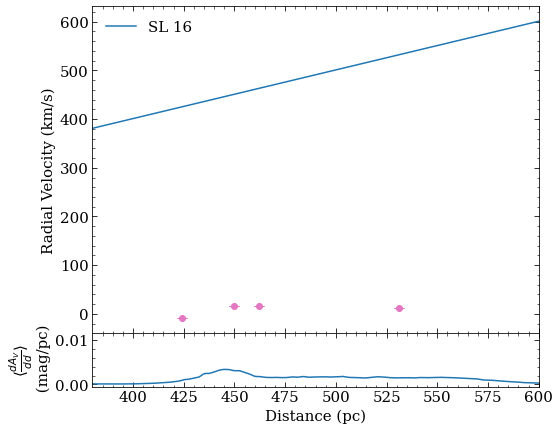

[202.86845398 410.74191284 428.74060059 483.35723877 551.98327637]
[-1.9897999  -3.28803173 -4.12172317  8.24144503  9.59662763]
[410.74191284 428.74060059 483.35723877 551.98327637]
(array([  0.09318787, -41.68896372]), array([[ 3.36838087e-04, -1.77101282e-01],
       [-1.77101282e-01,  9.39860394e+01]]))


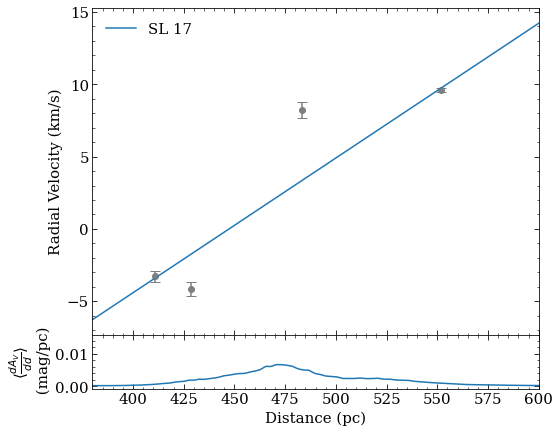

In [51]:
sightlines_slopes = np.zeros(len(sightlines))
sightlines_slopes_err = np.zeros(len(sightlines))
for i in range(len(sightlines)): 
    fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (8,7), sharex = True, gridspec_kw={'height_ratios': [6,1], 'hspace': 0})


    dist_xx = np.array([])
    velo_yy = np.array([])
    std_velo = np.array([])
    sl_i = sightlines[i]
    sampler_i = sl_i.sampler
    color = cmap(cnorm(avs[i]))
    color = 'C'+str(i)
    _, __, dist_xx_i, velo_yy_i, std_velo_i = plot_velo(sampler_i, sl = sl_i, min_walker = 10, plot_objs = (fig, axs[0]), color = color)
    dist_xx = np.concatenate([dist_xx, dist_xx_i])
    velo_yy = np.concatenate([velo_yy, velo_yy_i])
    std_velo = np.concatenate([std_velo, std_velo_i])

    print(dist_xx)
    print(velo_yy)

    dist_sort = np.argsort(dist_xx)
    # print(dist_sort)

    try:
        filt = (dist_xx[dist_sort] >= 380) & (dist_xx[dist_sort] <= 600)
        print(dist_xx[dist_sort][filt])
        fit_result = curve_fit(line, dist_xx[dist_sort][filt], velo_yy[dist_sort][filt], sigma = std_velo[dist_sort][filt])
        print(fit_result)
        fit_params = fit_result[0]
        fit_result_err = np.sqrt(np.diag(fit_result[1]))
        xx_plot = np.linspace(380, 600)

        axs[0].plot(xx_plot, line(xx_plot, fit_params[0], fit_params[1]), label = 'SL ' + str(i))
        sightlines_slopes[i] = fit_params[0] 
        sightlines_slopes_err[i] = fit_result_err[0]
    except Exception as e:
        print('didn\'t fit properly')
        print(e)
        sightlines_slopes[i] = np.nan

    # axs[0].fill_between(xx_plot, line(xx_plot, fit_params[0] + fit_result_err[0], fit_params[1] + fit_result_err[1]),
    #                     line(xx_plot, fit_params[0] - fit_result_err[0], fit_params[1] - fit_result_err[1]), alpha = 0.1, color = 'C0')

    # ymin, ymax = ax.get_ylim()
    axs[1].plot(distance, sl_davdd[i, :])
    # ax.set_ylim(ymin, ymax)
    axs[1].set_xlim(380, 600)
    axs[1].set_xlabel('Distance (pc)')
    axs[1].set_ylabel(r'$ \langle \frac{dA_V}{dd} \rangle $' + '\n (mag/pc)')
    fig.set_facecolor('white')
    # fig.colorbar(mappable, ax = axs[0], label = 'Sightline A(V) (mag)')
    axs[0].legend()

    # plt.savefig('output_sightlines_{}.png'.format(name), pad_inches = 0.3)
    plt.show()

ValueError: 'yerr' (shape: (5,)) must be a scalar or a 1D or (2, n) array-like whose shape matches 'y' (shape: (15,))

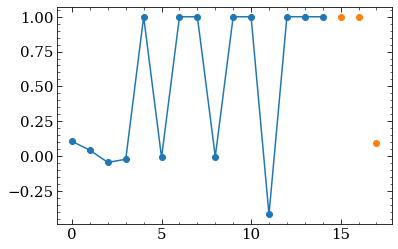

In [52]:
fig, ax = plt.subplots()
ax.scatter(np.arange(N_filament), sightlines_slopes[:N_filament], label = 'Filament')
ax.scatter(np.arange(N_filament, N_filament + N_background), sightlines_slopes[N_filament:], label = 'Off Filament')

ax.errorbar(np.arange(N_filament), sightlines_slopes[:N_filament], yerr = std_velo[:N_filament])
ax.errorbar(np.arange(N_filament, N_filament+N_background), sightlines_slopes[N_filament:], yerr = std_velo[N_filament:])


ax.plot((22, 22), (-0.4, 0.4), linestyle = 'dashed')
ax.set_xlabel('Sightline Index')
ax.set_ylabel('Fit Slope (km/s / pc)')

mean1, std1 = (np.nanmean(sightlines_slopes[:N_filament]), np.nanstd(sightlines_slopes[:N_filament], ddof = 1))
mean2, std2 = (np.nanmean(sightlines_slopes[N_filament:]), np.nanstd(sightlines_slopes[N_filament:], ddof = 1))

# ax.errorbar((22-0)/2 + 0, mean1, yerr = std1, c= 'k', capsize = 2, fmt = 'o')
# ax.errorbar((48-22)/2 + 22, mean2, yerr = std2, c= 'k', capsize = 2, fmt = 'o')

fig.set_facecolor('white')
plt.show()

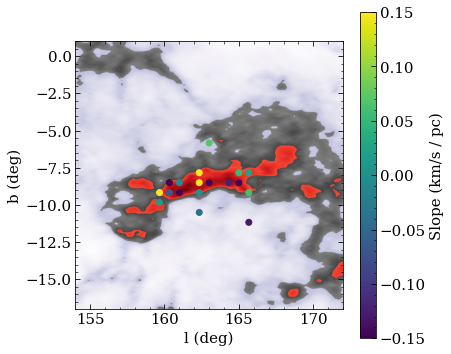

In [ ]:
fig, ax = plt.subplots(figsize = (6,6))
im = ax.imshow(np.nansum(edenhofer, axis = 2), origin = 'lower', cmap = 'binary', vmin = 0, vmax = 3, extent = (l0-9, l0+9, b0-9, b0+9))
masks = (np.nansum(edenhofer, axis = 2) >= 2.2).astype(float)
masks_3 = (np.nansum(edenhofer, axis = 2) < 1.5).astype(float)
im_mask = ax.imshow(np.nansum(edenhofer, axis = 2), origin = 'lower', cmap = 'Reds', alpha = masks, extent = (l0-9, l0+9, b0-9, b0+9))
im_mask_3 = ax.imshow(np.nansum(edenhofer, axis = 2), origin = 'lower', cmap = 'Purples', alpha = masks_3, extent = (l0-9, l0+9, b0-9, b0+9))
points = ax.scatter(l_sample[:], b_sample[:], c = sightlines_slopes[:], vmin = -0.15, vmax = 0.15)
ax.set_xlabel('l (deg)')
ax.set_ylabel('b (deg)')
# fig.colorbar(im, label = "A(V)")
fig.colorbar(points, label = 'Slope (km/s / pc)')
plt.show()

